#Packages to upload

In [1]:
!pip install stylecloud
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259494 sha256=9e261df97d6725cc807c8090f782a407eb087739fd8dee65da27f149c4ecab13
  Stored in directory: /root/.cache/pip/wheels/aa/c8/27/9374f4fc7133015d902b5e2c75ad951edd57eb1ae948495915
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=7cfd074132c61a29e029ce81a065e3f0fd291c6381bad757246185eecc26d2e1
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import spacy
import stylecloud
from IPython.display import Image
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import string
from transformers import pipeline, RobertaTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Sentiment analysis on data 2024-04-07

### Reading the view table data


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/capstone_drive/sentiment_comment_2024-04-07'

# Read the CSV file into a DataFrame
df_7 = pd.read_csv(file_path)

In [ ]:
df_7

,comment_id,comment_text,comment_score,post_tag,upload_time
0,138121103,"If I use SVG, which library is better?",0,charts,2024-04-07 00:00:00+00:00
1,138121103,"If I use SVG, which library is better?",0,javascript,2024-04-07 00:00:00+00:00
2,138121103,"If I use SVG, which library is better?",0,canvas,2024-04-07 00:00:00+00:00
3,138121103,"If I use SVG, which library is better?",0,easeljs,2024-04-07 00:00:00+00:00
4,138121103,"If I use SVG, which library is better?",0,pixi.js,2024-04-07 00:00:00+00:00
...,...,...,...,...,...
301378,137961549,Please provide enough code so others can bette...,0,unity-game-engine,2024-04-07 00:00:00+00:00
301379,137961549,Please provide enough code so others can bette...,0,python,2024-04-07 00:00:00+00:00
301380,137961549,Please provide enough code so others can bette...,0,macos,2024-04-07 00:00:00+00:00
301381,137961545,Please edit the question to limit it to a spec...,0,openai-api,2024-04-07 00:00:00+00:00


### filtering the rows (desired tags)

In [ ]:
programming_languages = [
    'python', 'c#', 'javascript', 'c++', 'java', 'php', 'sql',
    'postgres', 'rand', 'ruby', 'html', 'css', 'r'
]
# Filter DataFrame to include only these known languages
df_7 = df_7[df_7['post_tag'].isin(programming_languages)]

In [ ]:
def group_tags_with_other_columns(df):
    """
    Groups DataFrame by 'post_id', aggregates 'tag' into a list,
    and retains other columns without aggregation.
    """
    # Group by 'post_id' and aggregate 'tag' into a list
    tags_aggregated = df.groupby('comment_id')['post_tag'].apply(list).reset_index()

    # Get unique rows based on 'post_id' to retain other columns
    unique_rows = df.drop_duplicates(subset=['comment_id']).drop('post_tag', axis=1)

    # Merge the aggregated 'tags' with the unique rows
    final_df = pd.merge(tags_aggregated, unique_rows, on='comment_id')

    return final_df


In [ ]:
df_7 = group_tags_with_other_columns(df_7)

In [ ]:
df_7

,comment_id,post_tag,comment_text,comment_score,upload_time
0,137958303,[python],I would check what's being returned in `const ...,0,2024-04-07 00:00:00+00:00
1,137958306,"[java, java, java]",Or else your server is encountering an upstrea...,0,2024-04-07 00:00:00+00:00
2,137958308,[r],You should also look at your use-case. Will on...,0,2024-04-07 00:00:00+00:00
3,137958309,"[c++, c++, c++, c++, c++]",You might want to show your attempt as a [mcve].,0,2024-04-07 00:00:00+00:00
4,137958314,[java],"'*call-by-reference"" which isn't a thing*' - b...",0,2024-04-07 00:00:00+00:00
...,...,...,...,...,...
13690,138142088,"[html, html, html, html]",how can I make `5/15` readable for a screen re...,0,2024-04-07 00:00:00+00:00
13691,138142847,"[php, php]","That was the issue, thank you!",0,2024-04-07 00:00:00+00:00
13692,138144650,[c#],"So not to long after I posted this, I did end ...",0,2024-04-07 00:00:00+00:00
13693,138146281,"[python, python, python]",it states [here](https://realpython.com/python...,0,2024-04-07 00:00:00+00:00


### Data Processing




In [ ]:

# Initialize SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to extract code snippets from text
def extract_code(text):
    # Regular expression pattern to match code blocks enclosed in <code> tags
    pattern = r"<code>(.*?)</code>"
    # Find all code snippets in the text
    code_snippets = re.findall(pattern, text, flags=re.DOTALL)
    # Join the code snippets into a single string
    code = '\n'.join(code_snippets)
    return code

# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        # Remove HTML tags and code snippets
        cleaned_text = re.sub(r'<[^>]+>', '', text)
        cleaned_text = re.sub(r"<code>(.*?)</code>", '', cleaned_text, flags=re.DOTALL)
        # Remove special characters
        cleaned_text = re.sub(r'[^a-zA-Z\s.]+', '', cleaned_text)
        # Remove extra whitespaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        return cleaned_text.strip()
    return None


# Download stopwords if not already done
nltk.download('stopwords')

# Create a custom list of programming keywords to add to stop words
programming_keywords = [
    "def", "function", "return", "var", "const", "let", "console",
    "print", "import", "class", "this", "new", "try", "catch", "init","py"
]

# Function to remove stop words, including custom-defined words
def remove_custom_stop_words(tokens, custom_stop_words):
    """
    Removes English stop words and additional custom stop words from a list of tokenized words.
    """
    # Get the list of English stop words
    base_stop_words = set(stopwords.words('english'))

    # Combine base stop words with custom-defined stop words
    combined_stop_words = base_stop_words.union(custom_stop_words)

    # Filter out stop words from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in combined_stop_words]

    return filtered_tokens

# Function to tokenize at the sentence level
def tokenize_sentences(text):
    if isinstance(text, str):
        text = text.lower()
        # Split into sentences
        sentences = sent_tokenize(text)

        # Remove punctuation from each sentence
        sentences_no_punctuation = []
        for sentence in sentences:
            # Remove punctuation using string.punctuation
            cleaned_sentence = "".join(
                char for char in sentence if char not in string.punctuation
            )
            sentences_no_punctuation.append(cleaned_sentence.strip())

        return sentences_no_punctuation

    return []

# Function to lemmatize using SpaCy
def lemmatize(text):
    if isinstance(text, str):
        text = text.lower()
        doc = nlp(text)
        return [token.lemma_ for token in doc]
    return []

def remove_stop_words_from_sentence(sentence, custom_stop_words):
    """
    Tokenizes the sentence, removes stop words, and returns the cleaned sentence.
    """
    # Tokenize the sentence into words
    tokens = word_tokenize(sentence)

    # Remove stop words using the custom list
    filtered_tokens = remove_custom_stop_words(tokens, custom_stop_words)

    # Join the filtered tokens into a cleaned sentence
    cleaned_sentence = " ".join(filtered_tokens)

    return cleaned_sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_7['Cleaned Text'] = df_7['comment_text'].apply(clean_text)
df_7['Simple Tokens'] = df_7['Cleaned Text'].apply(lambda text: text.split())
df_7['NLTK Tokens'] = df_7['Cleaned Text'].apply(word_tokenize)
df_7['Sentences'] = df_7['Cleaned Text'].apply(tokenize_sentences)
df_7['Lemmas'] = df_7['Cleaned Text'].apply(lemmatize)

In [ ]:
df_7['filtered_tokens'] = df_7['Lemmas'].apply(
    lambda tokens: remove_custom_stop_words(tokens, programming_keywords)
)
df_7['filtered_text'] = df_7['Cleaned Text'].apply(
    lambda sent: remove_stop_words_from_sentence(sent, programming_keywords)
)

In [ ]:
df_7

,comment_id,post_tag,comment_text,comment_score,upload_time,Cleaned Text,Simple Tokens,NLTK Tokens,Sentences,Lemmas,filtered_tokens,filtered_text
0,137958303,[python],I would check what's being returned in `const ...,0,2024-04-07 00:00:00+00:00,i would check whats being returned in const da...,"[i, would, check, whats, being, returned, in, ...","[i, would, check, whats, being, returned, in, ...",[i would check whats being returned in const d...,"[I, would, check, what, s, be, return, in, con...","[would, check, datum, await, axios.postmyurlre...",would check whats returned data await axios.po...
1,137958306,"[java, java, java]",Or else your server is encountering an upstrea...,0,2024-04-07 00:00:00+00:00,or else your server is encountering an upstrea...,"[or, else, your, server, is, encountering, an,...","[or, else, your, server, is, encountering, an,...",[or else your server is encountering an upstre...,"[or, else, your, server, be, encounter, an, up...","[else, server, encounter, upstream, timeout, n...",else server encountering upstream timeout ther...
2,137958308,[r],You should also look at your use-case. Will on...,0,2024-04-07 00:00:00+00:00,you should also look at your usecase. will one...,"[you, should, also, look, at, your, usecase., ...","[you, should, also, look, at, your, usecase, ....","[you should also look at your usecase, will on...","[you, should, also, look, at, your, usecase, ....","[also, look, usecase, ., one, user, look, one,...",also look usecase . one user looking one two p...
3,137958309,"[c++, c++, c++, c++, c++]",You might want to show your attempt as a [mcve].,0,2024-04-07 00:00:00+00:00,you might want to show your attempt as a mcve.,"[you, might, want, to, show, your, attempt, as...","[you, might, want, to, show, your, attempt, as...",[you might want to show your attempt as a mcve],"[you, might, want, to, show, your, attempt, as...","[might, want, show, attempt, mcve, .]",might want show attempt mcve .
4,137958314,[java],"'*call-by-reference"" which isn't a thing*' - b...",0,2024-04-07 00:00:00+00:00,callbyreference which isnt a thing but can be ...,"[callbyreference, which, isnt, a, thing, but, ...","[callbyreference, which, isnt, a, thing, but, ...",[callbyreference which isnt a thing but can be...,"[callbyreference, which, be, not, a, thing, bu...","[callbyreference, thing, find, wikipediahttpse...",callbyreference isnt thing found wikipediahttp...
...,...,...,...,...,...,...,...,...,...,...,...,...
13690,138142088,"[html, html, html, html]",how can I make `5/15` readable for a screen re...,0,2024-04-07 00:00:00+00:00,how can i make readable for a screen reader,"[how, can, i, make, readable, for, a, screen, ...","[how, can, i, make, readable, for, a, screen, ...",[how can i make readable for a screen reader],"[how, can, I, make, readable, for, a, screen, ...","[make, readable, screen, reader]",make readable screen reader
13691,138142847,"[php, php]","That was the issue, thank you!",0,2024-04-07 00:00:00+00:00,that was the issue thank you,"[that, was, the, issue, thank, you]","[that, was, the, issue, thank, you]",[that was the issue thank you],"[that, be, the, issue, thank, you]","[issue, thank]",issue thank
13692,138144650,[c#],"So not to long after I posted this, I did end ...",0,2024-04-07 00:00:00+00:00,so not to long after i posted this i did end u...,"[so, not, to, long, after, i, posted, this, i,...","[so, not, to, long, after, i, posted, this, i,...",[so not to long after i posted this i did end ...,"[so, not, to, long, after, I, post, this, I, d...","[long, post, end, figure, however, memory, fai...",long posted end figuring however memory failin...
13693,138146281,"[python, python, python]",it states [here](https://realpython.com/python...,0,2024-04-07 00:00:00+00:00,it states herehttpsrealpython.compythonrequest...,"[it, states, herehttpsrealpython.compythonrequ...","[it, states, herehttpsrealpython.compythonrequ...",[it states herehttpsrealpythoncompythonrequest...,"[it, state, hereht

### Word Cloud

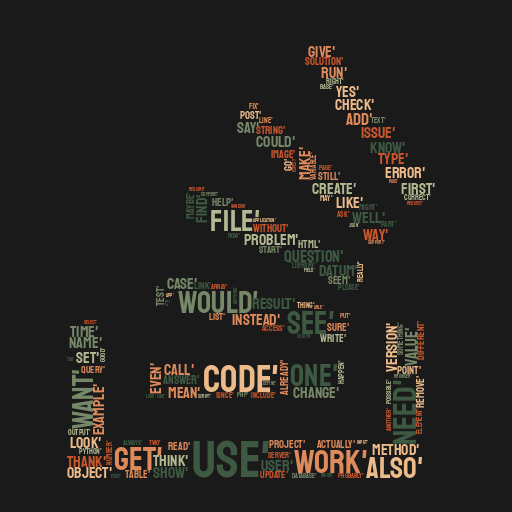

In [ ]:
df_7['filtered_tokens'].to_csv("tokens.csv",index= False)
stylecloud.gen_stylecloud(file_path='tokens.csv',background_color='#1A1A1A',icon_name= 'fab fa-stack-overflow',
                          palette="cartocolors.diverging.Fall_6" )
Image("stylecloud.png")

### Sentiment analysis with EmoRoBERTa model

#### April 1-7

In [ ]:
# Download the necessary nltk resources
import nltk
import time
from transformers import pipeline, RobertaTokenizer
import pandas as pd

nltk.download('punkt')

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="arpanghoshal/EmoRoBERTa")

# Initialize the tokenizer for the EmoRoBERTa model
tokenizer = RobertaTokenizer.from_pretrained("arpanghoshal/EmoRoBERTa")

# Function to safely determine sentiment and truncate text if too long
def safe_sentiment(text, tokenizer, max_length=512):
    # Convert to string if not already, handle None or NaN by returning None
    if not isinstance(text, str):
        return None

    # Tokenize the text and truncate if necessary
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > max_length:
        # Join tokens and then decode back to string
        truncated_text = tokenizer.decode(tokenized_text[:max_length])
    else:
        truncated_text = text

    try:
        # Perform sentiment analysis
        result = sentiment_pipeline(truncated_text)
        return result[0]['label']
    except Exception as e:
        print("Error processing text:", e)
        return None

# Set batch size
batch_size = 100

# Create a new column for sentiments and initialize it to None
df_7['sentence_sentiments'] = None

# Start the timer
start_time = time.time()

# Process in batches
total_rows = df_7.shape[0]
num_batches = (total_rows // batch_size) + 1

for batch_num in range(num_batches):
    # Define the range of rows to process in this batch
    start_index = batch_num * batch_size
    end_index = min((batch_num + 1) * batch_size, total_rows)

    # Process this batch
    df_7.loc[start_index:end_index-1, 'sentence_sentiments'] = df_7.loc[start_index:end_index-1, 'filtered_text'].apply(
        lambda x: safe_sentiment(x, tokenizer)
    )

    print(f"Processed batch {batch_num + 1}/{num_batches}")

# Stop the timer and print the total time taken
end_time = time.time()
print("Sentiment analysis complete.")
print(f"Total time taken: {end_time - start_time:.2f} seconds")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Processed batch 1/137
Processed batch 2/137
Processed batch 3/137
Processed batch 4/137
Processed batch 5/137
Processed batch 6/137
Processed batch 7/137
Processed batch 8/137
Processed batch 9/137
Processed batch 10/137
Processed batch 11/137
Processed batch 12/137
Processed batch 13/137
Processed batch 14/137
Processed batch 15/137
Processed batch 16/137
Processed batch 17/137
Processed batch 18/137
Processed batch 19/137
Processed batch 20/137
Processed batch 21/137
Processed batch 22/137
Processed batch 23/137
Processed batch 24/137
Processed batch 25/137
Processed batch 26/137
Processed batch 27/137
Processed batch 28/137
Processed batch 29/137
Processed batch 30/137
Processed batch 31/137
Processed batch 32/137
Processed batch 33/137
Processed batch 34/137
Processed batch 35/137
Processed batch 36/137
Processed batch 37/137
Processed batch 38/137
Processed batch 39/137
Processed batch 40/137
Processed batch 41/137
Processed batch 42/137
Processed batch 43/137
Processed batch 44/1

In [ ]:
# df.to_csv("sentiment_comment_2024-04-07")

### Further manipulations and visulizations

In [ ]:
rows_with_none = df_7[df_7['sentence_sentiments'].isnull()]

In [ ]:
df_7['sentence_sentiments'].unique()

array(['neutral', 'approval', 'remorse', 'admiration', 'disapproval',
       'gratitude', 'fear', 'disgust', 'realization', 'confusion',
       'optimism', 'curiosity', 'surprise', 'desire', 'caring', 'sadness',
       'annoyance', 'amusement', 'nervousness', 'disappointment',
       'relief', 'excitement', 'joy', 'pride', 'anger', 'embarrassment',
       'love'], dtype=object)

In [ ]:
df_7

,Unnamed: 0,comment_id,post_tag,comment_text,comment_score,upload_time,Cleaned Text,Simple Tokens,NLTK Tokens,Sentences,Lemmas,filtered_tokens,filtered_text,sentence_sentiments
0,0,137958303,['python'],I would check what's being returned in `const ...,0,2024-04-07 00:00:00+00:00,i would check whats being returned in const da...,"['i', 'would', 'check', 'whats', 'being', 'ret...","['i', 'would', 'check', 'whats', 'being', 'ret...",['i would check whats being returned in const ...,"['I', 'would', 'check', 'what', 's', 'be', 're...","['would', 'check', 'datum', 'await', 'axios.po...",would check whats returned data await axios.po...,neutral
1,1,137958306,"['java', 'java', 'java']",Or else your server is encountering an upstrea...,0,2024-04-07 00:00:00+00:00,or else your server is encountering an upstrea...,"['or', 'else', 'your', 'server', 'is', 'encoun...","['or', 'else', 'your', 'server', 'is', 'encoun...",['or else your server is encountering an upstr...,"['or', 'else', 'your', 'server', 'be', 'encoun...","['else', 'server', 'encounter', 'upstream', 't...",else server encountering upstream timeout ther...,neutral
2,2,137958308,['r'],You should also look at your use-case. Will on...,0,2024-04-07 00:00:00+00:00,you should also look at your usecase. will one...,"['you', 'should', 'also', 'look', 'at', 'your'...","['you', 'should', 'also', 'look', 'at', 'your'...","['you should also look at your usecase', 'will...","['you', 'should', 'also', 'look', 'at', 'your'...","['also', 'look', 'usecase', '.', 'one', 'user'...",also look usecase . one user looking one two p...,neutral
3,3,137958309,"['c++', 'c++', 'c++', 'c++', 'c++']",You might want to show your attempt as a [mcve].,0,2024-04-07 00:00:00+00:00,you might want to show your attempt as a mcve.,"['you', 'might', 'want', 'to', 'show', 'your',...","['you', 'might', 'want', 'to', 'show', 'your',...",['you might want to show your attempt as a mcve'],"['you', 'might', 'want', 'to', 'show', 'your',...","['might', 'want', 'show', 'attempt', 'mcve', '.']",might want show attempt mcve .,neutral
4,4,137958314,['java'],"'*call-by-reference"" which isn't a thing*' - b...",0,2024-04-07 00:00:00+00:00,callbyreference which isnt a thing but can be ...,"['callbyreference', 'which', 'isnt', 'a', 'thi...","['callbyreference', 'which', 'isnt', 'a', 'thi...",['callbyreference which isnt a thing but can b...,"['callbyreference', 'which', 'be', 'not', 'a',...","['callbyreference', 'thing', 'find', 'wikipedi...",callbyreference isnt thing found wikipediahttp...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13690,13690,138142088,"['html', 'html', 'html', 'html']",how can I make `5/15` readable for a screen re...,0,2024-04-07 00:00:00+00:00,how can i make readable for a screen reader,"['how', 'can', 'i', 'make', 'readable', 'for',...","['how', 'can', 'i', 'make', 'readable', 'for',...",['how can i make readable for a screen reader'],"['how', 'can', 'I', 'make', 'readable', 'for',...","['make', 'readable', 'screen', 'reader']",make readable screen reader,neutral
13691,13691,138142847,"['php', 'php']","That was the issue, thank you!",0,2024-04-07 00:00:00+00:00,that was the issue thank you,"['that', 'was', 'the', 'issue', 'thank', 'you']","['that', 'was', 'the', 'issue', 'thank', 'you']",['that was the issue thank you'],"['that', 'be', 'the', 'issue', 'thank', 'you']","['issue', 'thank']",issue thank,gratitude
13692,13692,138144650,['c#'],"So not to long after I posted this, I did end ...",0,2024-04-07 00:00:00+00:00,so not to long after i posted this i did end u...,"['so', 'not', 'to', 'long', 'after', 'i', 'pos...","['so', 'not', 'to', 'long', 'after', 'i', 'pos...",['so not to long after i posted this i did end...,"['so', 'not', 'to', 'long', 'after', 'I', 'pos...","['long', 'post', 'end', 'figure', 'however', '...",long posted end figuring however memory failin...,neutral
13693,13693,138146281,"['python', 'python', 'python']",it states [here](https://realpython.com/python...,0,20

In [ ]:
df_7['post_tag'] = df_7['post_tag'].astype(str)
def safe_eval(value):
    try:
        # Convert string to a list if it's a valid representation of a list
        if value.startswith("[") and value.endswith("]"):
            return eval(value)
        else:
            return [value]  # Convert non-list strings to a list with one element
    except Exception:
        return [value]
df_7['post_tag'] = df_7['post_tag'].apply(safe_eval)
df_7 = df_7.explode('post_tag')

In [ ]:
total_rows_7 = df_7.shape[0]

# Group by 'sentence_sentiments' and count the number of rows for each sentiment
sentiment_counts_7 = df_7['sentence_sentiments'].value_counts()

# Calculate the percentage of rows for each sentiment
sentiment_percentages_7 = (sentiment_counts_7 / total_rows_7) * 100
sentiment_percentages_7

sentence_sentiments
neutral           77.699162
gratitude          5.791894
approval           3.828465
disapproval        2.483030
confusion          1.663829
admiration         1.396290
remorse            1.124328
realization        0.943021
desire             0.777191
surprise           0.626838
curiosity          0.610255
caring             0.547239
optimism           0.537290
disappointment     0.360404
amusement          0.336082
annoyance          0.249851
fear               0.223318
disgust            0.184624
excitement         0.153669
joy                0.131559
sadness            0.129348
love               0.053066
anger              0.050855
embarrassment      0.044221
nervousness        0.030955
relief             0.021005
pride              0.002211
Name: count, dtype: float64

In [ ]:
grouped_7 = df_7.groupby(['post_tag', 'sentence_sentiments']).size().reset_index(name='count')

# Calculate the total count for each programming language tag
tag_totals_7 = grouped_7.groupby('post_tag')['count'].sum().reset_index(name='total_count')
grouped_with_totals_7 = grouped_7.merge(tag_totals_7, on='post_tag')
grouped_with_totals_7['percentage'] = (grouped_with_totals_7['count'] / grouped_with_totals_7['total_count']) * 100

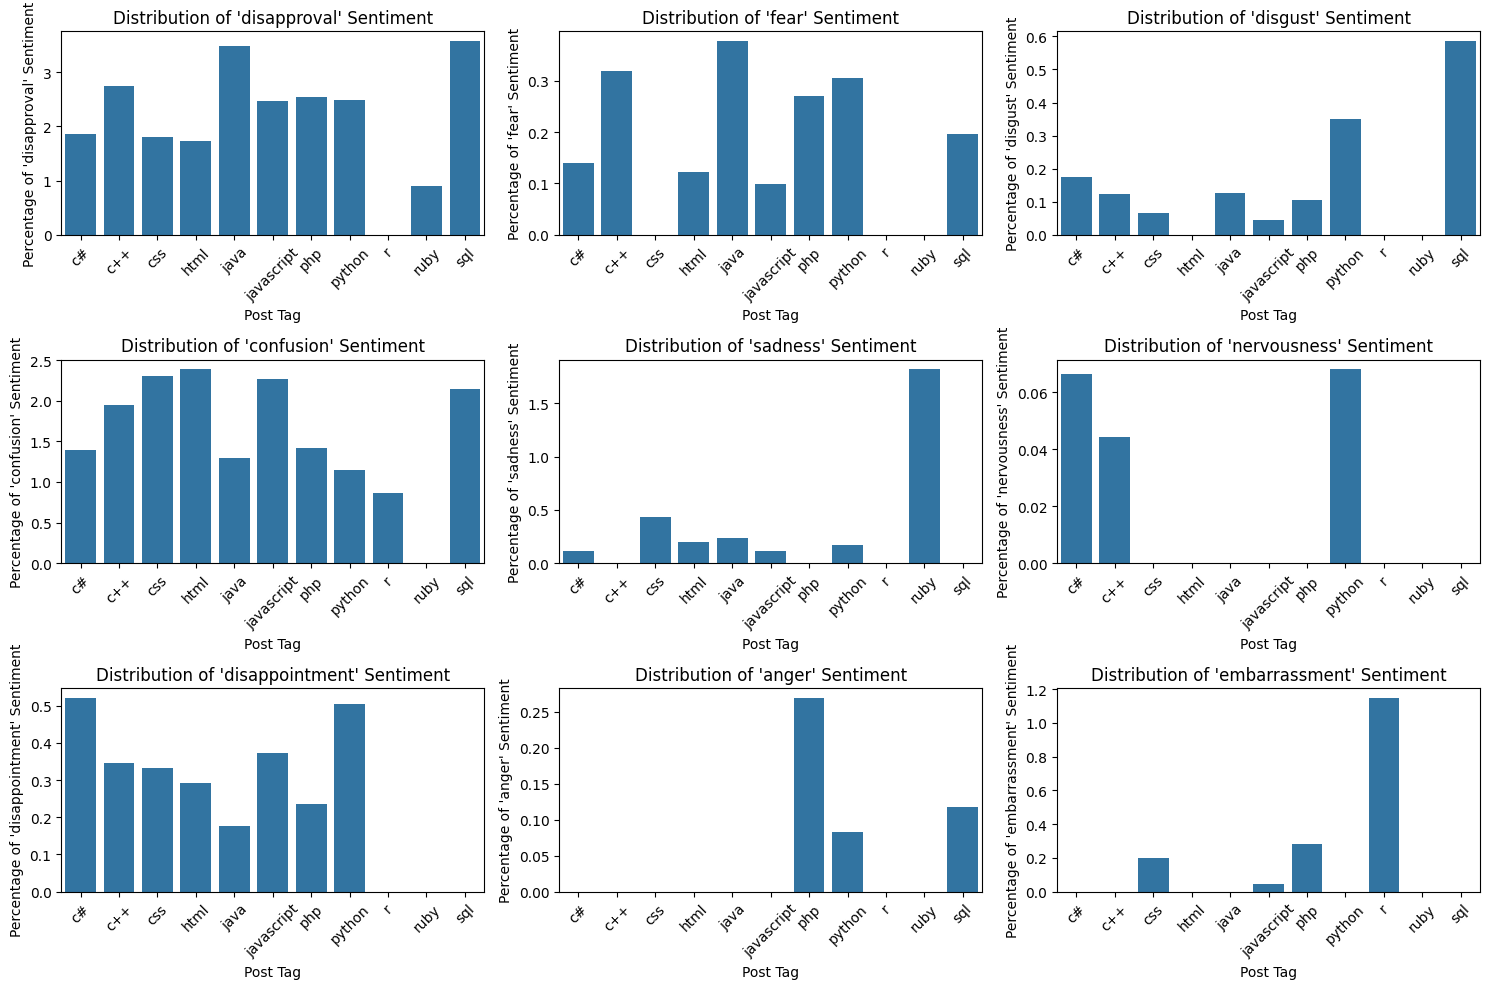

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'grouped_with_totals' is your existing DataFrame
# Create a pivot table showing sentiment distribution by some index (e.g., 'post_tag')
pivot_table = (
    grouped_with_totals_7.pivot_table(
        values='percentage',
        index='post_tag',  # or another suitable column to group by
        columns='sentence_sentiments',  # The sentiment column
        aggfunc='sum',
    )
)

# Select the target sentiments
target_sentiments = ['disapproval', 'fear', 'disgust', 'confusion', 'sadness', 'nervousness', 'disappointment', 'anger', 'embarrassment']
selected_pivot_table = pivot_table[target_sentiments]

# Plot all target sentiments in a grid of subplots with x-axis labels at a 45-degree angle
num_plots = len(target_sentiments)
num_cols = 3  # Set the number of columns for the grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the required rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, sentiment in enumerate(target_sentiments):
    sns.barplot(x=selected_pivot_table.index, y=selected_pivot_table[sentiment], ax=axes[i])
    axes[i].set_xlabel("Post Tag")  # Change as needed
    axes[i].set_ylabel(f"Percentage of '{sentiment}' Sentiment")
    axes[i].set_title(f"Distribution of '{sentiment}' Sentiment")

    # Rotate the x-axis labels
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'grouped_with_totals' is your existing DataFrame
# Create a pivot table showing sentiment distribution by some index (e.g., 'post_tag')
pivot_table = (
    grouped_with_totals_7.pivot_table(
        values='percentage',
        index='post_tag',  # or another suitable column to group by
        columns='sentence_sentiments',  # The sentiment column
        aggfunc='sum',
    )
)

# Select the target sentiments
target_sentiments = ['disapproval', 'fear', 'disgust', 'confusion', 'sadness', 'nervousness', 'disappointment', 'anger', 'embarrassment']
selected_pivot_table = pivot_table[target_sentiments]

# Find the tag with the highest percentage for each sentiment
max_sentiment_tags = selected_pivot_table.idxmax()  # This gives the tag with the highest value for each sentiment
max_sentiment_values = selected_pivot_table.max()  # This gives the maximum value for each sentiment

# Create a DataFrame to display the result in a tabular format
result_df = pd.DataFrame({
    'Sentiment': max_sentiment_tags.index,
    'Highest Tag': max_sentiment_tags.values,
    'Highest Percentage': max_sentiment_values.values,
})

# Display the table
print("Tag with the highest percentage for each sentiment:")
print(result_df.to_string(index=False))


Tag with the highest percentage for each sentiment:
     Sentiment Highest Tag  Highest Percentage
   disapproval         sql            3.574219
          fear        java            0.376979
       disgust         sql            0.585938
     confusion        html            2.385349
       sadness        ruby            1.818182
   nervousness      python            0.067935
disappointment          c#            0.521829
         anger         php            0.269605
 embarrassment           r            1.149425


In [ ]:
tag_counts_7 = df_7.groupby(['sentence_sentiments', 'post_tag']).size().reset_index(name='count')

# Find the most used tag for each sentiment
most_used_tag_7 = tag_counts_7.groupby('sentence_sentiments').apply(lambda x: x.loc[x['count'].idxmax()])

# Clean the resulting DataFrame for readability
most_used_tag_7 = most_used_tag_7.reset_index(drop=True)

# Display the DataFrame with most used tag for each sentiment
print("Most used tag for each unique sentiment:")
print(most_used_tag_7.to_string(index=False))

Most used tag for each unique sentiment:
sentence_sentiments   post_tag  count
         admiration     python    298
          amusement     python     93
              anger        php     23
          annoyance     python     44
           approval     python    844
             caring javascript     97
          confusion javascript    298
          curiosity     python    202
             desire     python    163
     disappointment     python    104
        disapproval     python    512
            disgust     python     72
      embarrassment        php     24
         excitement     python     48
               fear     python     63
          gratitude     python   1105
                joy javascript     33
               love javascript     17
        nervousness     python     14
            neutral     python  15935
           optimism javascript    112
              pride        sql      2
        realization        php    157
             relief        c++     19
         

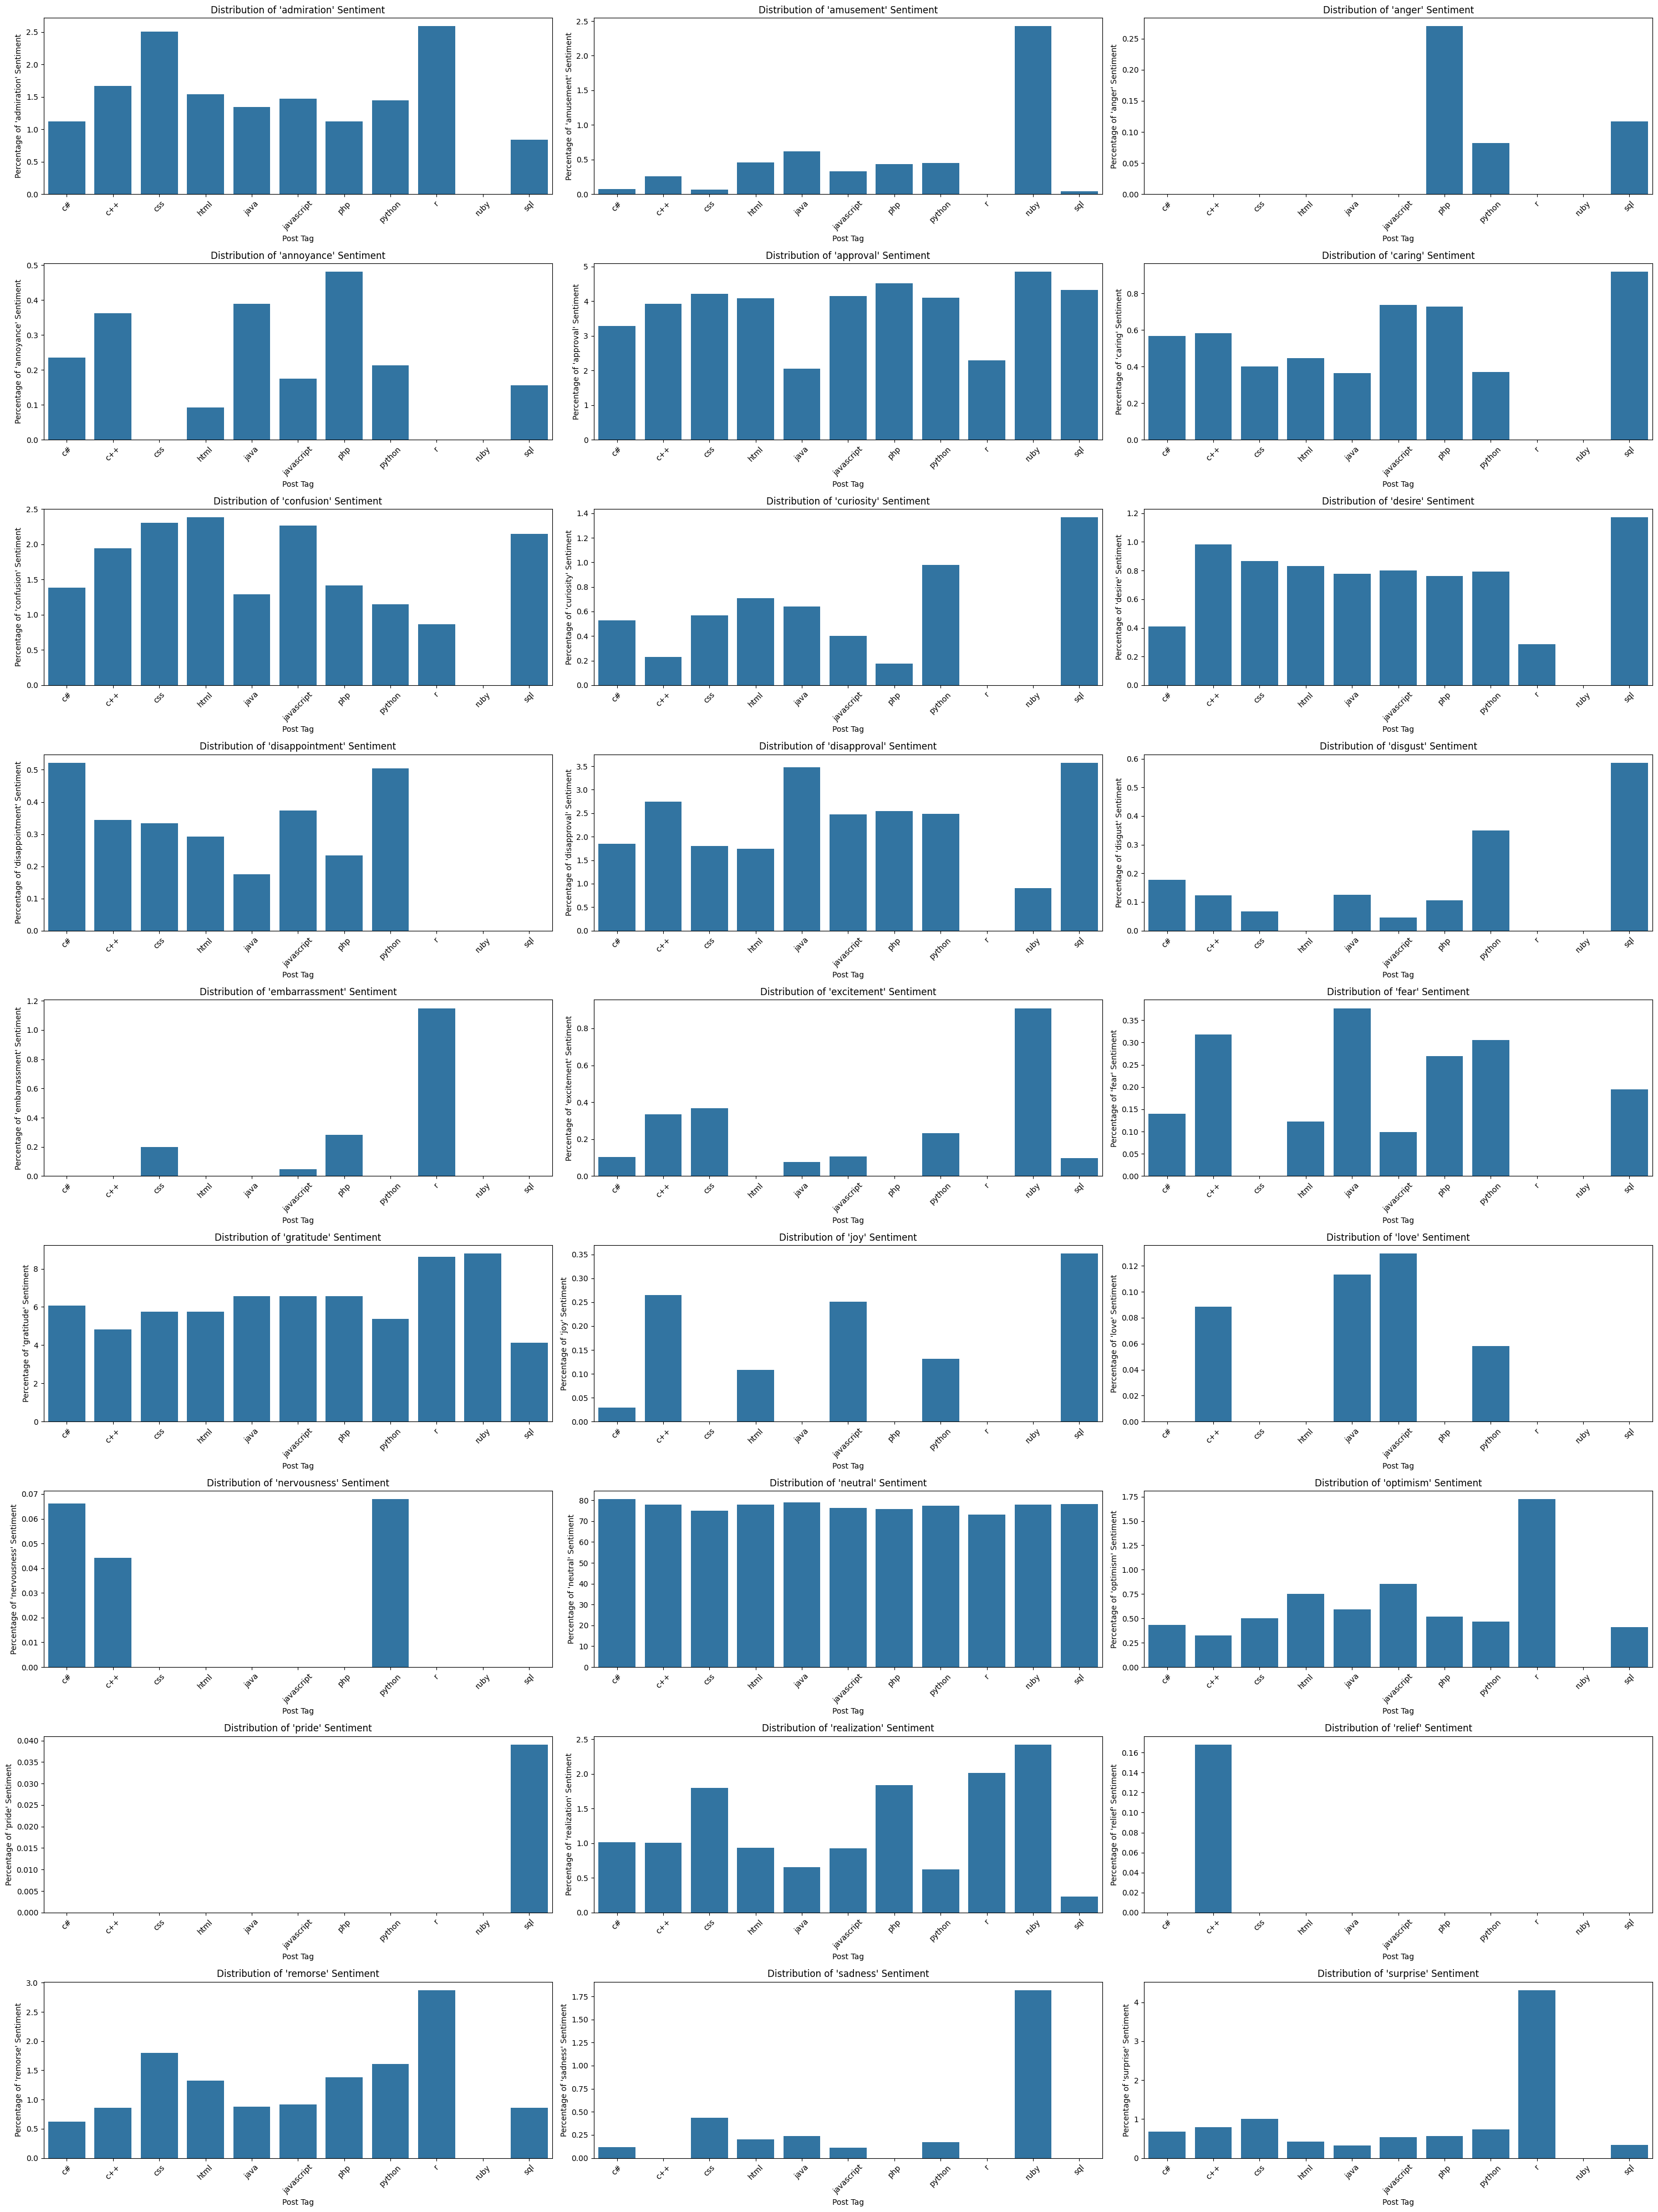

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table showing sentiment distribution by some index (e.g., 'post_tag')
pivot_table = (
    grouped_with_totals_7.pivot_table(
        values='percentage',
        index='post_tag',  # Group by this column
        columns='sentence_sentiments',  # Sentiment distribution
        aggfunc='sum',
    )
)

# Get all unique sentiments
target_sentiments = pivot_table.columns.tolist()

# Plot all sentiments in a grid of subplots with additional spacing and rotated x-axis labels
num_plots = len(target_sentiments)
num_cols = 3  # Number of columns for the grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 40))
axes = axes.flatten()

# Create a bar plot for each sentiment
for i, sentiment in enumerate(target_sentiments):
    sns.barplot(x=pivot_table.index, y=pivot_table[sentiment], ax=axes[i])
    axes[i].set_xlabel("Post Tag")  # Change as needed
    axes[i].set_ylabel(f"Percentage of '{sentiment}' Sentiment")
    axes[i].set_title(f"Distribution of '{sentiment}' Sentiment")

    # Rotate the x-axis labels for readability
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)  # You can adjust label size as needed

# Hide any unused axes (if the number of plots doesn't fill the grid)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust spacing between plots
plt.subplots_adjust(wspace=2, hspace=3)  # Increase horizontal and vertical spacing

plt.tight_layout()  # Ensure the plots are arranged properly without overlapping
plt.show()


# Sentiment analysis on 4 weeks (April month)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Weeks

#### April 1 - 7


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path_7 = '/content/drive/My Drive/capstone_drive/view_tables/view_comments_2024-04-07.csv'
df_7 = pd.read_csv(file_path_7)

In [ ]:
df_7.head(5)

#### April 8-14


In [ ]:
file_path_14 = '/content/drive/My Drive/capstone_drive/view_tables/view_comments_2024-04-14.csv'
df_14 = pd.read_csv(file_path_14)

In [ ]:
df_14.head(5)

#### April 15-21

In [7]:
file_path_21 = '/content/drive/My Drive/capstone_drive/view_tables/view_comments_2024-04-21.csv'
df_21 = pd.read_csv(file_path_21)

In [10]:
df_21.head(5)

,comment_id,comment_text,comment_score,post_tag,upload_time
0,138128706,<?php echo '<div>html stuff</div>?> Could be y...,1,php,2024-04-21 00:00:00+00:00
1,138128706,<?php echo '<div>html stuff</div>?> Could be y...,1,php,2024-04-21 00:00:00+00:00
2,138128706,<?php echo '<div>html stuff</div>?> Could be y...,1,php,2024-04-21 00:00:00+00:00
3,138128706,<?php echo '<div>html stuff</div>?> Could be y...,1,php,2024-04-21 00:00:00+00:00
4,138128706,<?php echo '<div>html stuff</div>?> Could be y...,1,php,2024-04-21 00:00:00+00:00


#### April 21-28


In [8]:
file_path_28 = '/content/drive/My Drive/capstone_drive/view_tables/view_comments_2024-04-28.csv'
df_28 = pd.read_csv(file_path_28)

In [9]:
df_28.head(5)

,comment_id,comment_text,comment_score,post_tag,upload_time
0,138205280,I think you should post this as a discussion s...,0,javascript,2024-04-28 00:00:00+00:00
1,138205280,I think you should post this as a discussion s...,0,javascript,2024-04-28 00:00:00+00:00
2,138205289,It depends if I was appending a large element ...,0,documentfragment,2024-04-28 00:00:00+00:00
3,138205289,It depends if I was appending a large element ...,0,documentfragment,2024-04-28 00:00:00+00:00
4,138205289,It depends if I was appending a large element ...,0,documentfragment,2024-04-28 00:00:00+00:00


## Functions for processing

In [11]:
# Initialize SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Filter DataFrame to include only these known languages
programming_languages = [
    'python', 'c#', 'javascript', 'c++', 'java', 'php', 'sql',
    'postgres', 'rand', 'ruby', 'html', 'css', 'r'
]

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

programming_keywords = [
    "def", "function", "return", "var", "const", "let", "console",
    "print", "import", "class", "this", "new", "try", "catch", "init", "py"
]

def group_tags_with_other_columns(df):
    """
    Groups DataFrame by 'comment_id', aggregates 'post_tag' into a list,
    and retains other columns without aggregation.
    """
    # Group by 'comment_id' and aggregate 'post_tag' into a list
    tags_aggregated = df.groupby('comment_id')['post_tag'].apply(list).reset_index()

    # Get unique rows based on 'comment_id' to retain other columns
    unique_rows = df.drop_duplicates(subset=['comment_id']).drop('post_tag', axis=1)

    # Merge the aggregated 'tags' with the unique rows
    final_df = pd.merge(tags_aggregated, unique_rows, on='comment_id')

    return final_df

def extract_code(text):
    """
    Extracts code snippets from text enclosed in <code> tags.
    """
    pattern = r"<code>(.*?)</code>"
    code_snippets = re.findall(pattern, text, flags=re.DOTALL)
    return '\n'.join(code_snippets)

def clean_text(text):
    """
    Cleans text by removing HTML tags, special characters, code snippets, and extra spaces.
    """
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
        text = re.sub(r"<code>(.*?)</code>", '', text, flags=re.DOTALL)  # Remove code snippets
        text = re.sub(r'[^a-zA-Z\s.]+', '', text)  # Remove special characters
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        return text.strip()
    return None

def remove_custom_stop_words(tokens, custom_stop_words):
    """
    Removes stop words, including custom-defined words, from a list of tokenized words.
    """
    base_stop_words = set(stopwords.words('english'))
    combined_stop_words = base_stop_words.union(custom_stop_words)
    filtered_tokens = [token for token in tokens if token.lower() not in combined_stop_words]
    return filtered_tokens

def tokenize_sentences(text):
    """
    Tokenizes text into sentences, removing punctuation.
    """
    if isinstance(text, str):
        sentences = sent_tokenize(text.lower())
        sentences_no_punctuation = [
            "".join(char for char in sentence if char not in string.punctuation).strip()
            for sentence in sentences
        ]
        return sentences_no_punctuation
    return []

def lemmatize(text):
    """
    Uses SpaCy to lemmatize text.
    """
    if isinstance(text, str):
        doc = nlp(text.lower())
        return [token.lemma_ for token in doc]
    return []

def remove_stop_words_from_sentence(sentence, custom_stop_words):
    """
    Tokenizes a sentence, removes stop words, and returns the cleaned sentence.
    """
    tokens = word_tokenize(sentence.lower())
    filtered_tokens = remove_custom_stop_words(tokens, custom_stop_words)
    return " ".join(filtered_tokens)

def process_dataframe(df):
    """
    Applies the given logic on the provided DataFrame and returns the processed DataFrame.
    """
    # Filter to only known programming languages
    df = df[df['post_tag'].isin(programming_languages)]
    df = group_tags_with_other_columns(df)
    # Add additional columns based on provided logic
    df['Cleaned Text'] = df['comment_text'].apply(clean_text)
    df['Simple Tokens'] = df['Cleaned Text'].apply(lambda text: text.split())
    df['NLTK Tokens'] = df['Cleaned Text'].apply(word_tokenize)
    df['Sentences'] = df['Cleaned Text'].apply(tokenize_sentences)
    df['Lemmas'] = df['Cleaned Text'].apply(lemmatize)
    df['filtered_tokens'] = df['Lemmas'].apply(lambda tokens: remove_custom_stop_words(tokens, programming_keywords))
    df['filtered_text'] = df['Cleaned Text'].apply(lambda sent: remove_stop_words_from_sentence(sent, programming_keywords))

    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Execution of Processeing functions on the tables


In [ ]:
df_7 = process_dataframe(df_7)
df_14 = process_dataframe(df_14)
df_21 = process_dataframe(df_21)

In [12]:
df_28 = process_dataframe(df_28)

## Sentiment anlaysing functions and Execution

In [13]:
import time
import nltk
from transformers import pipeline, RobertaTokenizer
import pandas as pd

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Initialize the sentiment analysis pipeline and tokenizer
sentiment_pipeline = pipeline("sentiment-analysis", model="arpanghoshal/EmoRoBERTa")
tokenizer = RobertaTokenizer.from_pretrained("arpanghoshal/EmoRoBERTa")

# Function to determine sentiment safely, handling edge cases and truncating text
def safe_sentiment(text, tokenizer, max_length=512):
    if not isinstance(text, str):
        return None  # Handle non-string or NaN values

    # Tokenize and truncate if necessary
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > max_length:
        truncated_text = tokenizer.decode(tokenized_text[:max_length])
    else:
        truncated_text = text

    try:
        # Perform sentiment analysis
        result = sentiment_pipeline(truncated_text)
        return result[0]['label']
    except Exception as e:
        print("Error processing text:", e)
        return None

# Function to process sentiment analysis in batches
def add_sentiments_to_dataframe(df, text_column='filtered_text', batch_size=100):
    """
    Add sentiment analysis to the specified text column in a DataFrame.
    """
    # Create a new column for sentiment results, initialized to None
    df['sentence_sentiments'] = None

    # Record the start time
    start_time = time.time()

    # Determine the total number of rows and calculate number of batches
    total_rows = df.shape[0]
    num_batches = (total_rows // batch_size) + 1

    # Process in batches
    for batch_num in range(num_batches):
        # Define the range of rows for this batch
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, total_rows)

        # Apply the sentiment analysis function to this batch
        df.loc[start_index:end_index-1, 'sentence_sentiments'] = df.loc[start_index:end_index-1, text_column].apply(
            lambda x: safe_sentiment(x, tokenizer)
        )

        print(f"Processed batch {batch_num + 1}/{num_batches}")

    # Record the end time and calculate the total time taken
    end_time = time.time()

    print("Sentiment analysis complete.")
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

    return df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
import time
import nltk
from transformers import pipeline, RobertaTokenizer
import pandas as pd

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Function to determine sentiment safely, handling edge cases and truncating text
def safe_sentiment(text, sentiment_pipeline, tokenizer, max_length=512):
    if not isinstance(text, str):
        return None  # Handle non-string or NaN values

    # Tokenize and truncate if necessary
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > max_length:
        truncated_text = tokenizer.decode(tokenized_text[:max_length])
    else:
        truncated_text = text

    try:
        # Perform sentiment analysis
        result = sentiment_pipeline(truncated_text)
        return result[0]['label']
    except Exception as e:
        print("Error processing text:", e)
        return None


# Function to process sentiment analysis in batches with a customizable sentiment pipeline and column name
def add_sentiments_to_dataframe_costom(df, text_column, sentiment_pipeline, tokenizer, output_column='sentence_sentiments', batch_size=100):
    """
    Add sentiment analysis to the specified text column in a DataFrame.
    Allows for customizable sentiment pipeline and output column name.
    """
    # Create a new column for sentiment results, initialized to None
    df[output_column] = None

    # Record the start time
    start_time = time.time()

    # Determine the total number of rows and calculate the number of batches
    total_rows = df.shape[0]
    num_batches = (total_rows // batch_size) + 1

    # Process in batches
    for batch_num in range(num_batches):
        # Define the range of rows for this batch
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, total_rows)

        # Apply the sentiment analysis function to this batch
        df.loc[start_index:end_index - 1, output_column] = df.loc[start_index:end_index - 1, text_column].apply(
            lambda x: safe_sentiment(x, sentiment_pipeline, tokenizer)
        )

        print(f"Processed batch {batch_num + 1}/{num_batches}")

    # Record the end time and calculate the total time taken
    end_time = time.time()

    print("Sentiment analysis complete.")
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

    return df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# VADER Sentiment Function
def vader_sentiment(text):
    vader_analyzer = SentimentIntensityAnalyzer()
    if not isinstance(text, str):
        return None

    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']

    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"



# Function to apply sentiment analysis and create new columns
def add_sentiment_vader(df, text_column_name='filtered_text'):
    df['vader_sentiment'] = df[text_column_name].apply(vader_sentiment)
    return df


#### April 8-14

In [ ]:
df_14 = add_sentiments_to_dataframe(df_14, text_column='filtered_text', batch_size=100)

Processed batch 1/160
Processed batch 2/160
Processed batch 3/160
Processed batch 4/160
Processed batch 5/160
Processed batch 6/160
Processed batch 7/160
Processed batch 8/160
Processed batch 9/160
Processed batch 10/160
Processed batch 11/160
Processed batch 12/160
Processed batch 13/160
Processed batch 14/160
Processed batch 15/160
Processed batch 16/160
Processed batch 17/160
Processed batch 18/160
Processed batch 19/160
Processed batch 20/160
Processed batch 21/160
Processed batch 22/160
Processed batch 23/160
Processed batch 24/160
Processed batch 25/160
Processed batch 26/160
Processed batch 27/160
Processed batch 28/160
Processed batch 29/160
Processed batch 30/160
Processed batch 31/160
Processed batch 32/160
Processed batch 33/160
Processed batch 34/160
Processed batch 35/160
Processed batch 36/160
Processed batch 37/160
Processed batch 38/160
Processed batch 39/160
Processed batch 40/160
Processed batch 41/160
Processed batch 42/160
Processed batch 43/160
Processed batch 44/1

In [ ]:
# defualt pipline
df_14 = add_sentiments_to_dataframe_costom(
    df_14,
    text_column='filtered_text',  # Column with the text to analyze
    sentiment_pipeline=pipeline('sentiment-analysis'),
    tokenizer=tokenizer,
    output_column='sentiment_BERT',  # Where to store the sentiment results
    batch_size=100  # Number of rows to process in each batch
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Processed batch 1/160
Processed batch 2/160
Processed batch 3/160
Processed batch 4/160
Processed batch 5/160
Processed batch 6/160
Processed batch 7/160
Processed batch 8/160
Processed batch 9/160
Processed batch 10/160
Processed batch 11/160
Processed batch 12/160
Processed batch 13/160
Processed batch 14/160
Processed batch 15/160
Processed batch 16/160
Processed batch 17/160
Processed batch 18/160
Processed batch 19/160
Processed batch 20/160
Processed batch 21/160
Processed batch 22/160
Processed batch 23/160
Processed batch 24/160
Processed batch 25/160
Processed batch 26/160
Processed batch 27/160
Processed batch 28/160
Processed batch 29/160
Processed batch 30/160
Processed batch 31/160
Processed batch 32/160
Processed batch 33/160
Processed batch 34/160
Processed batch 35/160
Processed batch 36/160
Processed batch 37/160
Processed batch 38/160
Processed batch 39/160
Processed batch 40/160
Processed batch 41/160
Processed batch 42/160
Processed batch 43/160
Processed batch 44/1

#### April 15-21

In [ ]:
df_21 = add_sentiments_to_dataframe(df_21, text_column='filtered_text', batch_size=100)

Processed batch 1/169
Processed batch 2/169
Processed batch 3/169
Processed batch 4/169
Processed batch 5/169
Processed batch 6/169
Processed batch 7/169
Processed batch 8/169
Processed batch 9/169
Processed batch 10/169
Processed batch 11/169
Processed batch 12/169
Processed batch 13/169
Processed batch 14/169
Processed batch 15/169
Processed batch 16/169
Processed batch 17/169
Processed batch 18/169
Processed batch 19/169
Processed batch 20/169
Processed batch 21/169
Processed batch 22/169
Processed batch 23/169
Processed batch 24/169
Processed batch 25/169
Processed batch 26/169
Processed batch 27/169
Processed batch 28/169
Processed batch 29/169
Processed batch 30/169
Processed batch 31/169
Processed batch 32/169
Processed batch 33/169
Processed batch 34/169
Processed batch 35/169
Processed batch 36/169
Processed batch 37/169
Processed batch 38/169
Processed batch 39/169
Processed batch 40/169
Processed batch 41/169
Processed batch 42/169
Processed batch 43/169
Processed batch 44/1

#### April 22-28

In [15]:
df_28 = add_sentiments_to_dataframe(df_28, text_column='filtered_text', batch_size=100)

Processed batch 1/162
Processed batch 2/162
Processed batch 3/162
Processed batch 4/162
Processed batch 5/162
Processed batch 6/162
Processed batch 7/162
Processed batch 8/162
Processed batch 9/162
Processed batch 10/162
Processed batch 11/162
Processed batch 12/162
Processed batch 13/162
Processed batch 14/162
Processed batch 15/162
Processed batch 16/162
Processed batch 17/162
Processed batch 18/162
Processed batch 19/162
Processed batch 20/162
Processed batch 21/162
Processed batch 22/162
Processed batch 23/162
Processed batch 24/162
Processed batch 25/162
Processed batch 26/162
Processed batch 27/162
Processed batch 28/162
Processed batch 29/162
Processed batch 30/162
Processed batch 31/162
Processed batch 32/162
Processed batch 33/162
Processed batch 34/162
Processed batch 35/162
Processed batch 36/162
Processed batch 37/162
Processed batch 38/162
Processed batch 39/162
Processed batch 40/162
Processed batch 41/162
Processed batch 42/162
Processed batch 43/162
Processed batch 44/1

In [22]:
df_7 = add_sentiment_vader(df_7)
df_14 = add_sentiment_vader(df_14)
df_21 = add_sentiment_vader(df_21)

In [66]:
df_28 = add_sentiment_vader(df_28)

# Reading the Sentiment Analyised files with EmoRoBerta and Vader


In [21]:
#Sentiments on EmoRobertA model with Vader analysis
from google.colab import drive
drive.mount('/content/drive')
file_path_7 = '/content/drive/My Drive/capstone_drive/sentiment_wvader_7.csv'
file_path_14 = '/content/drive/My Drive/capstone_drive/sentiment_wvader_14.csv'
file_path_21 = '/content/drive/My Drive/capstone_drive/sentiment_wvader_21.csv'
file_path_28 = '/content/drive/My Drive/capstone_drive/sentiment_wvader_28.csv'
# Read the CSV file into a DataFrame
df_7 = pd.read_csv(file_path_7)
df_14 = pd.read_csv(file_path_14)
df_21 = pd.read_csv(file_path_21)
df_28 = pd.read_csv(file_path_28)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Sentiments on EmoRobertA model without Vader analysis
# from google.colab import drive
# drive.mount('/content/drive')
# file_path_7 = '/content/drive/My Drive/capstone_drive/sentiment_comment_2024-04-07'
# file_path_14 = '/content/drive/My Drive/capstone_drive/sentiment_comments_2024-04-14.csv'
# file_path_21 = '/content/drive/My Drive/capstone_drive/sentiment_comment_2024-04-21'

# # Read the CSV file into a DataFrame
# df_7 = pd.read_csv(file_path_7)
# df_14 = pd.read_csv(file_path_14)
# df_21 = pd.read_csv(file_path_21)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_14['sentence_sentiments'].unique()

array(['neutral', 'confusion', 'approval', 'gratitude', 'remorse',
       'desire', 'admiration', 'disapproval', 'optimism', 'love',
       'realization', 'fear', 'curiosity', 'amusement', 'excitement',
       'caring', 'disgust', 'sadness', 'anger', 'disappointment',
       'annoyance', 'surprise', 'joy', 'nervousness', 'pride',
       'embarrassment', 'relief'], dtype=object)

In [ ]:
df_21['sentence_sentiments'].unique()

array(['neutral', 'nervousness', 'gratitude', 'confusion', 'disapproval',
       'approval', 'disappointment', 'amusement', 'annoyance',
       'realization', 'admiration', 'curiosity', 'joy', 'optimism',
       'desire', 'surprise', 'disgust', 'sadness', 'fear', 'remorse',
       'excitement', 'caring', 'embarrassment', 'anger', 'love', 'relief'],
      dtype=object)

In [ ]:
disgust_df = df_7[df_7['sentence_sentiments'] == 'disgust']
disgust_df['Cleaned Text'][57]

'it gets weirder. i will edit my original message'

In [ ]:
angry_df = df_14[df_14['sentence_sentiments'] == 'anger']['Cleaned Text']
angry_df[398]

'p.p.s. your testinput function is completely nonsenical junk and is a commonlyfound cargocult function which supposedly sanitises data whatever that really means. in fact its far more likely to accidentally modify the data for no good reason. it doesnt protect against sql injection it may trim or change data without good cause and it htmlencodes it at a time when the data isnt being used in a html document which is pointless and potentially destructive. just get rid of that function completely please its useless and harmful.'

In [ ]:
angry_df = df_14[df_14['sentence_sentiments'] == 'anger']['Cleaned Text']
angry_df[14331]

'this sucks so much. i just dont get how people can bear so many config files in the project root.'

In [ ]:
angry_df = df_14[df_14['sentence_sentiments'] == 'anger']['Cleaned Text']
angry_df[12527]

'i have tried about different ways but none of them work is not useful information apart from that it conveys that you are frustrated because it doesnt actually tell us what else you tried. but people will help you even if youre not frustrated. if you want to show additional relevant things youve tried then show them. otherwise you can probably delete that sentence and trust that people will help you even if youve only tried other ways. the fact that youve tried many things before asking should be true of every question on so so its not necessary to say explicitly.'

In [ ]:
annoyance_df = df_21[df_21['sentence_sentiments'] == 'annoyance']['Cleaned Text']
annoyance_df[8905]

'why do you create a nested multipart message when you only have one piece of content anyway the new api shields you from that kind of nonsense.'

In [ ]:
disgust_df = df_21[df_21['sentence_sentiments'] == 'disgust']['Cleaned Text']
disgust_df[3409]

'it looks ugly... that is subjective. what is the real problem'

In [55]:
anger_df = df_28[df_28['sentence_sentiments'] == 'anger']['Cleaned Text']
anger_df[11335]

'this is very annoying honestly'

## Data manipulation function (explodeing the tags)

In [23]:
import pandas as pd

def explode_and_deduplicate(dataframe):
    def safe_eval(value):
        try:
            # Convert string to a list if it's a valid representation of a list
            if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
                # Use literal_eval for safer evaluation instead of eval
                from ast import literal_eval
                return literal_eval(value)
            else:
                return [value]  # Convert non-list strings to a list with one element
        except Exception:
            return [value]

    # Ensure the specified column is treated as a string
    dataframe["post_tag"] = dataframe["post_tag"].astype(str)

    # Apply the safe_eval function to the specified column
    dataframe["post_tag"] = dataframe["post_tag"].apply(safe_eval)

    # Explode the specified column
    exploded_df = dataframe.explode("post_tag")

    # Drop duplicates based on 'comment_id' and the specified column
    # Ensure 'comment_id' exists in the DataFrame, or adjust if needed
    exploded_df = exploded_df.drop_duplicates(subset=['comment_id', "post_tag"])

    return exploded_df



## Results analysing functions


In [24]:
import pandas as pd

def calculate_sentiment_percentages(dataframe):
    # Get the total number of rows in the DataFrame
    total_rows = dataframe.shape[0]

    # Count the number of rows for each unique value in the specified sentiment column
    sentiment_counts = dataframe['sentence_sentiments'].value_counts()

    # Calculate the percentage for each sentiment
    sentiment_percentages = (sentiment_counts / total_rows) * 100

    print(f"total rows of the data: {total_rows}")

    return sentiment_counts, sentiment_percentages


In [25]:
def get_grouped_with_totals(dataframe):
    # Group by 'post_tag' and 'sentence_sentiments' and calculate the counts
    grouped = dataframe.groupby(['post_tag', 'sentence_sentiments']).size().reset_index(name='count')

    # Calculate the total count for each 'post_tag'
    tag_totals = grouped.groupby('post_tag')['count'].sum().reset_index(name='total_count')

    return grouped, tag_totals
# Function to calculate percentages from the grouped data

def calculate_percentage_from_grouped(grouped, tag_totals):
    """
    Merges grouped data with total counts and calculates the percentage for each sentiment.

    Parameters:
    - grouped (pd.DataFrame): The grouped DataFrame with counts.
    - tag_totals (pd.DataFrame): The DataFrame with total counts for each 'post_tag'.

    Returns:
    - pd.DataFrame: The merged DataFrame with calculated percentages.
    """
    # Merge the grouped data with the total counts
    grouped_with_totals = grouped.merge(tag_totals, on='post_tag')

    # Calculate the percentage for each sentiment
    grouped_with_totals['percentage'] = (grouped_with_totals['count'] / grouped_with_totals['total_count']) * 100

    return grouped_with_totals


In [26]:
# This functions gives the tags of sentimetns with highst percentage

def get_negative_and_other_results(df):
    # Step 1: Filter out 'neutral' sentiments
    filtered_df = df[df['sentence_sentiments'] != 'neutral']

    # Step 2: Group by 'post_tag' and 'sentence_sentiments', then count the occurrences
    tag_sentiment_count = filtered_df.groupby(['post_tag', 'sentence_sentiments']).size().reset_index(name='count')

    # Step 3: Get the total count for each tag
    tag_total_count = filtered_df.groupby('post_tag').size().reset_index(name='total_count')

    # Step 4: Merge the sentiment counts with the total counts for the percentage calculation
    merged_df = pd.merge(tag_sentiment_count, tag_total_count, on='post_tag')

    # Step 5: Calculate the percentage for each sentiment within each tag
    merged_df['sentiment_percentage'] = (merged_df['count'] / merged_df['total_count']) * 100

    # Step 6: Get the maximum sentiment percentage for each sentiment
    result = merged_df.loc[merged_df.groupby('sentence_sentiments')['sentiment_percentage'].idxmax()]

    # Define the list of negative sentiments
    negative_sentiments = ['anger', 'annoyance', 'disgust', 'fear', 'sadness', 'shame', 'remorse']

    # Step 7: Filter to get only negative sentiments
    negative_result = result[result['sentence_sentiments'].isin(negative_sentiments)]

    # Step 8: Get the DataFrame for non-negative sentiments
    other_result = result[~result['sentence_sentiments'].isin(negative_sentiments)]

    # Return both the negative results and the other results
    return negative_result, other_result

In [27]:
# This functions gives the the last two tags of sentimetns with 2 highest percentages

def get_last_two_per_sentiment_with_negative(df):
    # Step 1: Group by 'post_tag' and 'sentence_sentiments', then count the occurrences
    tag_sentiment_count = df.groupby(['post_tag', 'sentence_sentiments']).size().reset_index(name='count')

    # Step 2: Get the total count for each tag
    tag_total_count = df.groupby('post_tag').size().reset_index(name='total_count')

    # Step 3: Merge the sentiment counts with the total counts for the percentage calculation
    merged_df = pd.merge(tag_sentiment_count, tag_total_count, on='post_tag')

    # Step 4: Calculate the percentage for each sentiment within each tag
    merged_df['sentiment_percentage'] = (merged_df['count'] / merged_df['total_count']) * 100

    # Step 5: Sort by 'sentence_sentiments' and 'sentiment_percentage' in ascending order
    sorted_df = merged_df.sort_values(['sentence_sentiments', 'sentiment_percentage'], ascending=[True, True])

    # Step 6: Get the last two tag names for each sentiment
    last_two_per_sentiment = sorted_df.groupby('sentence_sentiments').tail(2)

    # Step 7: Define the list of negative sentiments
    negative_sentiments = ['anger', 'annoyance', 'disgust', 'fear', 'sadness', 'shame', 'remorse']

    # Step 8: Get the last two for only negative sentiments
    negative_result = last_two_per_sentiment[last_two_per_sentiment['sentence_sentiments'].isin(negative_sentiments)]

    return last_two_per_sentiment, negative_result


#### Results tables execution

In [28]:
def run_single_analysis(df):
    df_exploded = explode_and_deduplicate(df)
    sentiment_counts, sentiment_percentages = calculate_sentiment_percentages(df_exploded)
    grouped, tag_totals = get_grouped_with_totals(df_exploded)
    grouped_with_totals = calculate_percentage_from_grouped(grouped, tag_totals)
    negative_result, other_result = get_negative_and_other_results(df_exploded)
    last_2_per_sentiment, last_2_negative_result = get_last_two_per_sentiment_with_negative(df_exploded)
    last_2_negative_result = last_2_negative_result.sort_values('sentence_sentiments', ascending=True)

    # Return all the calculated results in a dictionary
    return df_exploded,sentiment_counts,sentiment_percentages,grouped_with_totals,negative_result,other_result,last_2_per_sentiment,last_2_negative_result


In [58]:
# Analysis function with a single DataFrame
# Analysis function with a single DataFrame
df_exploded_7,sentiment_counts_7,sentiment_percentages_7,grouped_with_totals_7,negative_result_7,other_result_7,last_2_per_sentiment_7,last_2_negative_result_7 = run_single_analysis(df_7)
df_exploded_14,sentiment_counts_14,sentiment_percentages_14,grouped_with_totals_14,negative_result_14,other_result_14,last_2_per_sentiment_14,last_2_negative_result_14 = run_single_analysis(df_14)
df_exploded_21,sentiment_counts_21,sentiment_percentages_21,grouped_with_totals_21,negative_result_21,other_result_21,last_2_per_sentiment_21,last_2_negative_result_21 = run_single_analysis(df_21)
df_exploded_28,sentiment_counts_28,sentiment_percentages_28,grouped_with_totals_28,negative_result_28,other_result_28,last_2_per_sentiment_28,last_2_negative_result_28 = run_single_analysis(df_28)

total rows of the data: 15207
total rows of the data: 17592
total rows of the data: 18399
total rows of the data: 17692


In [30]:
sentiment_percentages_7 = pd.DataFrame(sentiment_percentages_7)
sentiment_percentages_14 = pd.DataFrame(sentiment_percentages_14)
sentiment_percentages_21 = pd.DataFrame(sentiment_percentages_21)
sentiment_percentages_28 = pd.DataFrame(sentiment_percentages_28)
# Merge the DataFrames on the sentiment column
merged_data_1 = pd.merge(sentiment_percentages_7, sentiment_percentages_14, on='sentence_sentiments', suffixes=('_7', '_14'))
merged_data_2 = pd.merge(sentiment_percentages_21, sentiment_percentages_28, on='sentence_sentiments',suffixes=('_21','_28'))
merged_data = pd.merge(merged_data_1,merged_data_2 , on='sentence_sentiments')
merged_data

,count_7,count_14,count_21,count_28
sentence_sentiments,,,,
neutral,78.213980,77.455662,78.335779,78.459191
gratitude,6.201092,5.991360,5.837274,5.895320
approval,3.662787,3.984766,3.869776,3.713543
disapproval,2.341027,2.404502,2.309908,2.379607
confusion,1.440126,1.352888,1.309854,1.345241
admiration,1.275728,1.330150,1.326159,1.316979
remorse,1.006116,0.966348,0.885918,0.921320
realization,0.907477,0.932242,0.951139,0.910016
desire,0.749655,0.682128,0.586988,0.785666


In [31]:
# last 2 negative reulsts of largest percentages for negativ sentiments for week 7
last_2_negative_result_7

,post_tag,sentence_sentiments,count,total_count,sentiment_percentage
192,sql,anger,1,855,0.116959
129,php,anger,4,1167,0.342759
85,java,annoyance,5,1594,0.313676
130,php,annoyance,5,1167,0.428449
158,python,disgust,12,3702,0.324149
200,sql,disgust,4,855,0.467836
95,java,fear,5,1594,0.313676
140,php,fear,5,1167,0.428449
61,css,remorse,9,594,1.515152
145,php,remorse,19,1167,1.628106


In [ ]:
# last 2 negative reulsts of largest percentages for negativ sentiments for week 7
last_2_negative_result_14

,post_tag,sentence_sentiments,count,total_count,sentiment_percentage
116,javascript,anger,3,2601,0.115340
2,c#,anger,4,2207,0.181242
141,php,annoyance,5,1003,0.498504
194,ruby,annoyance,1,84,1.190476
11,c#,disgust,15,2207,0.679656
197,ruby,disgust,1,84,1.190476
104,java,fear,11,2239,0.491291
13,c#,fear,12,2207,0.543725
192,r,remorse,2,128,1.562500
68,css,remorse,13,812,1.600985


In [ ]:
last_2_negative_result_21

,post_tag,sentence_sentiments,count,total_count,sentiment_percentage
26,c++,anger,2,2082,0.096061
112,javascript,anger,3,2585,0.116054
194,ruby,annoyance,1,98,1.020408
183,r,annoyance,1,93,1.075269
216,sql,disgust,3,821,0.365408
35,c++,disgust,9,2082,0.432277
218,sql,fear,4,821,0.487211
37,c++,fear,14,2082,0.672430
154,php,remorse,15,1250,1.200000
66,css,remorse,9,680,1.323529


In [56]:
last_2_negative_result_28

,post_tag,sentence_sentiments,count,total_count,sentiment_percentage
197,sql,anger,1,1020,0.098039
66,html,anger,1,989,0.101112
67,html,annoyance,3,989,0.303337
132,php,annoyance,7,1115,0.627803
96,java,disgust,8,2145,0.372960
35,c++,disgust,9,2297,0.391815
37,c++,fear,8,2297,0.348280
207,sql,fear,4,1020,0.392157
63,css,remorse,9,684,1.315789
83,html,remorse,14,989,1.415571


Throughout the analysis, the feelings of **sadness** and **remorse** were consistently observed in the comments related to the `css` tag. This pattern remained unchanged across all the weeks that were examined, indicating a persistent trend in the sentiments associated with CSS-related discussions.

Furthermore, there were two separate weeks where sentiments of **anger** were repeatedly detected in comments linked to the `javascript` tag. This could suggest recurring issues or frustrations among JavaScript developers during those particular weeks.

Similarly, the sentiment of **annoyance** was frequently associated with the `php` tag during those two weeks, indicating that PHP-related topics might have been a source of irritation for users at that time.

The intenste negative sentiment for the `c++` was huge of **disgust** as well which persisted for the 2 weeks stright


This are the top tags with the hisghest **negtaive sentiments** percentage for each week


In [ ]:
negative_result_21[["post_tag","sentence_sentiments",	"sentiment_percentage"]]

,post_tag,sentence_sentiments,sentiment_percentage
107,javascript,anger,0.534759
185,ruby,annoyance,4.347826
34,c++,disgust,1.882845
36,c++,fear,2.928870
63,css,remorse,6.164384
82,html,sadness,1.415094


In [ ]:
negative_result_14[["post_tag","sentence_sentiments",	"sentiment_percentage"]]

,post_tag,sentence_sentiments,sentiment_percentage
2,c#,anger,0.881057
185,ruby,annoyance,5.555556
188,ruby,disgust,5.555556
13,c#,fear,2.643172
65,css,remorse,6.250000
21,c#,sadness,1.101322


In [ ]:
negative_result_7[["post_tag","sentence_sentiments",	"sentiment_percentage"]]

,post_tag,sentence_sentiments,sentiment_percentage
123,php,anger,1.433692
124,php,annoyance,1.792115
190,sql,disgust,2.083333
134,php,fear,1.792115
138,php,remorse,6.810036
179,ruby,sadness,6.250000


In [57]:
negative_result_28[["post_tag","sentence_sentiments",	"sentiment_percentage"]]

,post_tag,sentence_sentiments,sentiment_percentage
63,html,anger,0.490196
126,php,annoyance,3.097345
92,java,disgust,1.773836
197,sql,fear,1.877934
79,html,remorse,6.862745
21,c#,sadness,1.282051


In [49]:
vader_proportions_14 =df_14['vader_sentiment'].value_counts(normalize=True)
vader_proportions_21 =df_21['vader_sentiment'].value_counts(normalize=True)
vader_proportions_7 =df_7['vader_sentiment'].value_counts(normalize=True)
vader_proportions_28 =df_28['vader_sentiment'].value_counts(normalize=True)
merged_proportions = pd.concat(
    [vader_proportions_14.rename('vader_14'),
     vader_proportions_21.rename('vader_21'),
     vader_proportions_7.rename('vader_7'),
     vader_proportions_28.rename('vader_28')],
    axis=1
)
merged_proportions.fillna(0, inplace=True)

# Step 3: Calculate the average of each sentiment score
merged_proportions['average'] = merged_proportions.mean(axis=1)
merged_proportions

,vader_14,vader_21,vader_7,vader_28,average
vader_sentiment,,,,,
Positive,0.485779,0.477531,0.492147,0.482175,0.484408
Neutral,0.320650,0.327838,0.317189,0.318505,0.321045
Negative,0.193571,0.194631,0.190664,0.199320,0.194547


## Visualizations functions

In [34]:
def plot_sentiment_distribution(dataframe):
    # Group the data by 'post_tag' and 'sentence_sentiments' and calculate counts
    grouped = dataframe.groupby(['post_tag', 'sentence_sentiments']).size().reset_index(name='count')

    # Calculate the total count for each 'post_tag'
    tag_totals = grouped.groupby('post_tag')['count'].sum().reset_index(name='total_count')

    # Merge the grouped data with the total counts
    grouped_with_totals = grouped.merge(tag_totals, on='post_tag')

    # Calculate the percentage for each 'post_tag' and 'sentence_sentiments'
    grouped_with_totals['percentage'] = (grouped_with_totals['count'] / grouped_with_totals['total_count']) * 100

    # Create a pivot table to analyze sentiment distribution by 'post_tag'
    pivot_table = grouped_with_totals.pivot_table(
        values='percentage',
        index='post_tag',
        columns='sentence_sentiments',
        aggfunc='sum'
    )

    # Get the list of unique sentiments from the pivot table columns
    target_sentiments = pivot_table.columns.tolist()

    # Set the number of rows and columns for subplots
    num_plots = len(target_sentiments)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create subplots with the calculated grid size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    axes = axes.flatten()  # Flatten to iterate easily

    # Create a bar plot for each unique sentiment
    for i, sentiment in enumerate(target_sentiments):
        sns.barplot(x=pivot_table.index, y=pivot_table[sentiment], ax=axes[i])
        axes[i].set_xlabel("Post Tag")
        axes[i].set_ylabel(f"Percentage of '{sentiment}' Sentiment")
        axes[i].set_title(f"Distribution of '{sentiment}' Sentiment")
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels for readability

    # Hide any unused axes if the number of plots doesn't fill the grid
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust spacing between plots
    plt.subplots_adjust(wspace=2, hspace=3)  # Adjust spacing between plots

    plt.tight_layout()  # Adjust plots to ensure proper arrangement
    plt.show()

In [35]:
# Define a function to prepare data and separate neutral sentiments
def prepare_highest_and_other_with_neutral(df, threshold):
    """
    Categorizes a DataFrame into high-percentage sentiments, combines smaller sentiments into 'Other',
    and separates neutral sentiment to a different axis.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing sentiment data.
    - threshold (float): The threshold for high-percentage sentiments.

    Returns:
    - tuple(pd.DataFrame, pd.DataFrame): A tuple containing DataFrames for non-neutral and neutral data.
    """
    # Separate neutral sentiment
    df_neutral = df[df['sentence_sentiments'] == 'neutral']

    # Separate high-percentage sentiments and the rest
    df_non_neutral = df[df['sentence_sentiments'] != 'neutral']
    df_highest = df_non_neutral[df_non_neutral['percentage'] > threshold]
    df_other = df_non_neutral[df_non_neutral['percentage'] <= threshold]

    # Compute the combined "other" sentiment percentage
    other_percentage = df_other['percentage'].sum()

    # Create a DataFrame for the "other" category
    other_data = pd.DataFrame({
        'sentence_sentiments': ['Other'],
        'percentage': [other_percentage]
    })

    # Combine high-percentage sentiments with the "Other" category
    df_combined = pd.concat([df_highest, other_data], ignore_index=True)

    return df_combined, df_neutral

In [36]:
# Function to create a pivot table from grouped data
def create_pivot_table(dataframe):
    """
    Creates a pivot table to show the distribution of sentiments across programming languages.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with grouped sentiments data.

    Returns:
    - pd.DataFrame: The resulting pivot table.
    """
    # Remove neutral sentiments
    grouped_sentiments = dataframe[dataframe['sentence_sentiments'] != "neutral"]

    # Generate the pivot table to show sentiment distribution across programming language tags
    pivot_table = (
        grouped_sentiments.pivot_table(
            values='percentage',
            index='post_tag',  # Changed from 'tag' to 'post_tag'
            columns='sentence_sentiments',
            aggfunc='sum',
        )
    )

    return pivot_table


# Function to generate bar plots for each sentiment from the pivot table
def plot_sentiments_from_pivot(pivot_table):
    """
    Generates separate bar plots for each sentiment from a pivot table.

    Parameters:
    - pivot_table (pd.DataFrame): The pivot table with sentiment distribution across programming languages.

    Returns:
    - None
    """
    # Get the list of unique sentiments
    unique_sentiments = pivot_table.columns.tolist()

    # Generate separate plots for each sentiment
    for sentiment in unique_sentiments:
        plt.figure(figsize=(8, 6))
        sns.barplot(
            data=pivot_table.reset_index(),  # Resetting index to access 'post_tag'
            x='post_tag',
            y=sentiment,
            order=sorted(pivot_table.index),  # Sorting for consistent order
        )
        plt.xlabel("Programming Language")
        plt.ylabel(f"Percentage of '{sentiment}' Sentiment")
        plt.title(f"Distribution of '{sentiment}' Sentiment Across Programming Languages")
        plt.show()


# Combined function to create a pivot table and generate plots
def create_pivot_and_plot(dataframe):
    """
    Creates a pivot table and generates bar plots for each sentiment.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with grouped sentiments data.

    Returns:
    - pd.DataFrame: The pivot table used for plotting.
    """
    # Create the pivot table
    pivot_table = create_pivot_table(dataframe)

    # Generate the plots from the pivot table
    plot_sentiments_from_pivot(pivot_table)

    return pivot_table




In [37]:
def plot_bubble_chart(dataframe, drop_sentiment='neutral', color_palette='viridis'):
    """
    Plot a bubble chart with tags on the x-axis and sentiments on the y-axis.
    The function drops rows with the specified sentiment (default is 'neutral').

    Parameters:
    - dataframe: pd.DataFrame, input DataFrame with 'post_tag', 'sentence_sentiments', 'percentage' columns.
    - drop_sentiment: str, sentiment to drop from the DataFrame (default is 'neutral').
    - color_palette: str, name of the color palette to use for mapping (default is 'plasma').
    """

    # Drop the rows with the specified sentiment
    df = dataframe[dataframe['sentence_sentiments'] != drop_sentiment]

    # Create a unique color mapping based on the remaining sentiment types
    unique_sentiments = df['sentence_sentiments'].unique()
    palette = sns.color_palette(color_palette, len(unique_sentiments))
    color_dict = dict(zip(unique_sentiments, palette))

    # Assign colors to the sentiments based on the new palette
    df['colors'] = df['sentence_sentiments'].map(color_dict)

    # Plotting the bubble chart without the specified sentiment
    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['post_tag'],  # X-axis: Tags
        df['sentence_sentiments'],  # Y-axis: Sentiments
        s=df['percentage'] * 80,  # Bubble size
        alpha=0.6,  # Transparency for overlapping bubbles
        c=df['colors'],  # Color based on the sentiment mapping
        edgecolors='w',  # White edges for better separation
        linewidth=1  # Line width for the edge color
    )

    # Rotate x-axis labels at 45 degrees for readability
    plt.xticks(rotation=45)

    # Label the axes and add a title
    plt.xlabel('Tags')  # The x-axis represents different tags
    plt.ylabel('Sentiments')  # The y-axis represents different sentiments
    plt.title(f'Bubble Chart (Without "{drop_sentiment.capitalize()}" Sentiment)')

    # Display the chart
    plt.show()

In [38]:
negative_sentiments = ['anger', 'annoyance', 'disgust', 'fear', 'sadness', 'shame', 'remorse']
def plot_bubble_chart_for_negative(dataframe, negative_sentiments, color_palette='YlOrRd'):
    """
    Plot a bubble chart for specified negative sentiments with swapped x and y axes.

    Parameters:
    - dataframe: pd.DataFrame, input DataFrame with 'post_tag', 'sentence_sentiments', 'percentage' columns.
    - negative_sentiments: list of str, list of negative sentiment names to filter.
    - color_palette: str, name of the color palette to use for mapping (default is 'YlOrRd').
    """

    # Filter the DataFrame to include only specified negative sentiments
    df = dataframe[dataframe['sentence_sentiments'].isin(negative_sentiments)]

    # Create a unique color mapping based on the remaining negative sentiment types
    unique_sentiments = df['sentence_sentiments'].unique()
    palette = sns.color_palette(color_palette, len(unique_sentiments))
    color_dict = dict(zip(unique_sentiments, palette))

    # Assign colors to the negative sentiments based on the new palette
    df['colors'] = df['sentence_sentiments'].map(color_dict)

    # Plotting the bubble chart with swapped x and y axes
    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['sentence_sentiments'],  # X-axis: Negative sentiments
        df['post_tag'],  # Y-axis: Tags
        s=df['percentage'] * 500,  # Bubble size (scaled)
        alpha=1,  # Transparency for overlapping bubbles
        c=df['colors'],  # Color mapping from unique sentiments
        edgecolors='w',  # White edges for better separation
        linewidth=1  # Line width for the edge color
    )

    # Rotate x-axis labels at 45 degrees for readability
    plt.xticks(rotation=45)

    # Label the axes and set a chart title
    plt.xlabel('Negative Sentiments')  # The x-axis represents negative sentiments
    plt.ylabel('Tags')  # The y-axis represents different tags
    plt.title('Bubble Chart for Negative Sentiments (Swapped Axes)')

    # Display the chart
    plt.show()  # Show the bubble chart


In [39]:
# Function to generate beautiful bar plots for each sentiment from a pivot table
def plot_sentiments_from_pivot(pivot_table):
    """
    Generates separate bar plots for each sentiment from a pivot table with enhanced aesthetics.

    Parameters:
    - pivot_table (pd.DataFrame): The pivot table with sentiment distribution across programming languages.

    Returns:
    - None
    """
    # Get the list of unique sentiments
    unique_sentiments = pivot_table.columns.tolist()

    # Define a color palette for consistent and visually appealing colors
    color_palette = sns.color_palette("husl", len(unique_sentiments))  # "husl" for vibrant, distinct colors

    # Generate separate plots for each sentiment
    for i, sentiment in enumerate(unique_sentiments):
        plt.figure(figsize=(10, 6))  # Larger figure size for better clarity

        # Bar plot with improved aesthetics
        sns.barplot(
            data=pivot_table.reset_index(),  # Resetting index to access 'post_tag'
            x='post_tag',  # x-axis with programming languages
            y=sentiment,  # y-axis with sentiment percentage
            order=sorted(pivot_table.index),  # Sort for consistent order
            palette=color_palette,  # Use the color palette
            saturation=0.8  # Adjust saturation for brighter colors
        )

        # Set the plot title and axis labels with improved formatting
        plt.title(f"Distribution of '{sentiment}' Sentiment Across Programming Languages", fontsize=14, fontweight='bold')
        plt.xlabel("Programming Language", fontsize=12)  # Larger font size for x-axis label
        plt.ylabel(f"Percentage of '{sentiment}' Sentiment", fontsize=12)  # Larger font size for y-axis label

        # Add gridlines for better visual guidance
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)  # Subtle gridlines on the y-axis

        # Rotate x-axis labels for improved readability
        plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and align x-axis labels

        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()  # Display the plot


In [40]:
# Corrected list of negative sentiments
negative_sentiments_list = ['anger', 'annoyance', 'embarrassment', 'fear', 'nervousness', 'sadness', 'disappointment']

# Function to get the maximum percentage for each sentiment (corrected)
def get_max_percentage(dataframe, sentiment_column='sentence_sentiments', value_column='percentage', negative_sentiments=None):
    """
    Returns a dictionary with the maximum percentage for each unique sentiment, optionally filtering to specific sentiments.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame.
    - sentiment_column: str, the name of the column containing sentiment names.
    - value_column: str, the column used to determine intensity (e.g., 'percentage').
    - negative_sentiments: list, optional, a list of specific sentiments to filter.

    Returns:
    - dict, a dictionary with unique sentiments as keys and maximum percentages as values.
    """
    if negative_sentiments:
        # Filter the DataFrame to include only specified negative sentiments
        dataframe = dataframe[dataframe[sentiment_column].isin(negative_sentiments)]

    # Group by sentiment and find the maximum percentage in each group
    max_values = dataframe.groupby(sentiment_column)[value_column].max()
    return max_values.to_dict()

# Function to plot the bubble chart with color intensity based on the maximum percentage for each sentiment
def plot_bubble_chart_with_color_by_max_intensity(dataframe, max_percentages, sentiment_column='sentence_sentiments', color_palette='YlOrRd'):
    """
    Plot a bubble chart with color intensity based on the maximum percentage for each sentiment.

    Parameters:
    - dataframe: pd.DataFrame, input DataFrame with 'post_tag', 'sentence_sentiments', 'percentage' columns.
    - max_percentages: dict, a dictionary with the maximum percentage for each unique sentiment.
    - color_palette: str, name of the color palette to use for mapping (default is 'YlOrRd').
    """
    negative_sentiments_list = ['anger', 'annoyance', 'embarrassment', 'fear', 'nervousness', 'sadness', 'disappointment']
    dataframe = dataframe[dataframe[sentiment_column].isin(negative_sentiments_list)]
    # Assign color intensity based on maximum percentage for each sentiment
    dataframe['color_intensity'] = dataframe[sentiment_column].map(lambda s: max_percentages[s])

    # Create a unique color mapping based on the color palette
    unique_sentiments = list(max_percentages.keys())
    palette = sns.color_palette(color_palette, len(unique_sentiments))

    # Create the bubble chart with color intensity
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        dataframe['sentence_sentiments'],  # X-axis: Sentiments
        dataframe['post_tag'],  # Y-axis: Tags
        s=dataframe['percentage'] * 500,  # Bubble size
        alpha=1,  # Transparency
        c=dataframe['color_intensity'],  # Color intensity based on the maximum percentage
        cmap=color_palette,  # Color map to represent intensity
        edgecolors='w',  # White edges for separation
        linewidth=1  # Line width for the edge color
    )

    # Add a color bar to indicate the range of the maximum percentage
    plt.colorbar(scatter, label='Max Percentage')  # Label for the color bar

    # Rotate x-axis labels at 45 degrees for readability
    plt.xticks(rotation=45)

    # Label the axes and set a chart title
    plt.xlabel('Sentiments')  # The x-axis represents sentiments
    plt.ylabel('Tags')  # The y-axis represents tags
    plt.title('Bubble Chart (Color Intensity by Max Percentage)')

    # Display the chart
    plt.show()  # Show the bubble chart



In [ ]:
# def plot_pie_chart_with_threshold(dataframe, value_column, threshold=1, color_palette='Paired', startangle=90, figsize=(12, 8)):
#     """
#     Plot a pie chart with a custom autopct threshold and a separate legend for labels.

#     Parameters:
#     - dataframe: pd.DataFrame, the input DataFrame.
#     - value_column: str, the column with the pie chart data.
#     - threshold: float, the minimum percentage to display.
#     - color_palette: str, the colormap to use for the pie chart.
#     - startangle: int, the starting angle for the pie chart.
#     - figsize: tuple, the figure size for the plot.
#     """

#     # Define a function for autopct with a threshold
#     def autopct_with_threshold(threshold):
#         def display(value):
#             # Calculate the percentage
#             percentage = value * 100
#             # Show the percentage only if it's above the threshold
#             return f"{percentage:.1f}%" if percentage >= threshold else ''
#         return display

#     # Create a figure with the specified size
#     plt.figure(figsize=figsize)

#     # Plot the pie chart with the specified color palette and custom autopct
#     wedges, texts, autotexts = plt.pie(
#         dataframe[value_column],  # Pie chart data
#         autopct=autopct_with_threshold(threshold),  # Custom autopct with threshold
#         startangle=startangle,  # Start angle for the pie chart
#         colors=plt.cm.get_cmap(color_palette)(range(len(dataframe))),  # Color palette
#         shadow=True,  # Adds a shadow for visual depth
#         labeldistance=1.2  # This removes labels from the pie chart
#     )

#     # Title and axis setting for the pie chart
#     plt.title("Sentiment Percentage Distribution", fontsize=14)
#     plt.axis('equal')  # Ensures the pie chart is a perfect circle

#     # Add a legend to display labels separately from the pie chart
#     plt.legend(wedges, dataframe.index, title="Sentiments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

#     # Display the pie chart
#     plt.show()

In [41]:
# Define a list of negative sentiments
negative_sentiments_list = ['anger', 'annoyance', 'fear', 'embarrassment', 'nervousness', 'sadness', 'disappointment']

# Filter the DataFrame to include only specified negative sentiments

# Function to normalize percentages
def normalize_percentage(dataframe, value_column='percentage'):
    """
    Normalize the percentage values to a range between 0 and 1.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame.
    - value_column: str, the column used to determine percentage.

    Returns:
    - pd.DataFrame, the DataFrame with normalized percentage.
    """
    min_value = dataframe[value_column].min()
    max_value = dataframe[value_column].max()
    dataframe['normalized_percentage'] = (dataframe[value_column] - min_value) / (max_value - min_value)
    return dataframe

# Normalize the percentages for negative sentiments

# Function to plot the bubble chart with color gradient based on the normalized percentage
def plot_bubble_chart_with_gradient(dataframe, color_palette='viridis'):
    """
    Plot a bubble chart with a color gradient based on the normalized percentage, where higher percentages are red.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame with 'post_tag', 'sentence_sentiments', 'normalized_percentage' columns.
    - color_palette: str, the color palette to use for the gradient (default is 'Reds').
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        dataframe['sentence_sentiments'],  # X-axis: Sentiments
        dataframe['post_tag'],  # Y-axis: Tags
        s=dataframe['percentage'] * 600,  # Bubble size based on the percentage
        alpha=1,  # Full color intensity
        c=dataframe['normalized_percentage'],  # Color intensity based on the normalized percentage
        cmap=color_palette,  # Use a color palette for the gradient
        edgecolors='w',  # White edges for separation
        linewidth=1  # Line width for the edge color
    )

    # Rotate x-axis labels at 45 degrees for readability
    plt.xticks(rotation=45)

    # Add a color bar to indicate the range of percentages
    plt.colorbar(scatter, label='Normalized Percentage')  # Label for the color bar

    # Label the axes and set a chart title
    plt.xlabel('Sentiments')  # The x-axis represents sentiments
    plt.ylabel('Tags')  # The y-axis represents different tags
    plt.title('Bubble Chart Based on Normalized Percentage')

    # Display the chart
    plt.show()  # Show the bubble chart


In [42]:
def plot_pie_chart(dataframe, threshold=0.5):
    # Combine smaller slices into an "Others" category
    large_slices = dataframe[dataframe >= threshold]
    small_slices = dataframe[dataframe < threshold]

    if len(small_slices) > 0:
        others_sum = small_slices.sum()
        large_slices['Others'] = others_sum

    # Create a vibrant color palette with a colormap
    color_palette = plt.cm.tab20b_r(np.linspace(0, 1, len(large_slices)))

    plt.figure(figsize=(10, 6))  # Adjusted figure size

    # Plot the pie chart without autopct
    wedges, texts = plt.pie(
        large_slices.values,
        startangle=90,  # Start the pie chart from a 90-degree angle
        colors=color_palette,
        shadow=False
    )

    # Prepare custom legend labels with sentiment and percentage
    legend_labels = [f"{sentiment}: {percentage:.1f}%" for sentiment, percentage in zip(large_slices.index, large_slices.values)]

    # Title and axis setting for the pie chart
    plt.title("Sentiment Percentage Distribution", fontsize=14)
    plt.axis('equal')  # Ensures the pie chart is a perfect circle

    # Add the legend with custom labels and enhanced contrast
    plt.legend(
        wedges,
        legend_labels,
        title="Sentiments",
        loc="center left",
        bbox_to_anchor=(0.8, 0.5),  # Anchor the legend just outside the plot
        frameon=True,  # Optional frame to help delineate the legend
        fontsize=10,
        title_fontsize=14,
    )

    # Display the pie chart
    plt.show()

In [43]:
def generate_wordcloud(dataframe, tag_name, output_file="wordcloud.png"):
    # Filter the DataFrame by the given tag
    df_filtered = dataframe[dataframe["post_tag"] == tag_name]

    # Save the filtered tokens to a CSV file for stylecloud to read
    token_file = f"tokens_{tag_name}.csv"
    df_filtered["filtered_tokens"].to_csv(token_file, index=False)

    # Generate the word cloud using stylecloud
    stylecloud.gen_stylecloud(
        file_path=token_file,  # Path to the CSV file with tokens
        background_color="#1A1A1A",  # Background color for the word cloud
        icon_name="fab fa-stack-overflow",  # Icon for the word cloud
        palette="cartocolors.diverging.Fall_6",  # Color palette
        output_name=output_file,  # Output file for the word cloud
    )

    # Display the word cloud
    return Image(output_file)


### Visualizations

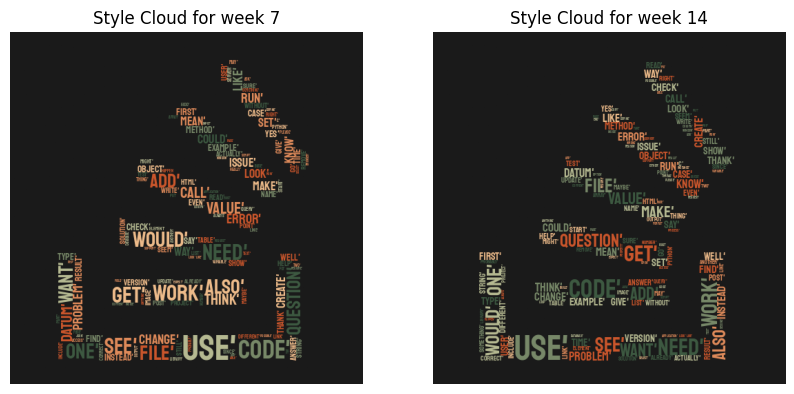

In [44]:
df_7['filtered_tokens'].to_csv("tokens_df_7.csv",index= False)
df_14['filtered_tokens'].to_csv("tokens_df_14.csv",index= False)
# Generate style cloud for df_7
stylecloud.gen_stylecloud(
    file_path="tokens_df_7.csv",  # CSV with tokens for the first style cloud
    background_color="#1A1A1A",
    icon_name="fab fa-stack-overflow",
    palette="cartocolors.diverging.Fall_6",
    output_name="stylecloud_7.png",  # Save to this file
)

# Generate style cloud for df_14
stylecloud.gen_stylecloud(
    file_path="tokens_df_14.csv",  # CSV with tokens for the second style cloud
    background_color="#1A1A1A",
    icon_name="fab fa-stack-overflow",
    palette="cartocolors.diverging.Fall_6",
    output_name="stylecloud_14.png",  # Save to this file
)

# Load the generated style clouds
img1 = mpimg.imread("stylecloud_7.png")  # The first style cloud
img2 = mpimg.imread("stylecloud_14.png")  # The second style cloud

# Create a subplot with 1 row and 2 columns to display the clouds side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the style clouds
ax[0].imshow(img1)
ax[0].axis("off")  # Hide axes
ax[0].set_title("Style Cloud for week 7")

ax[1].imshow(img2)
ax[1].axis("off")  # Hide axes
ax[1].set_title("Style Cloud for week 14")

# Show the plot with both style clouds
plt.show()


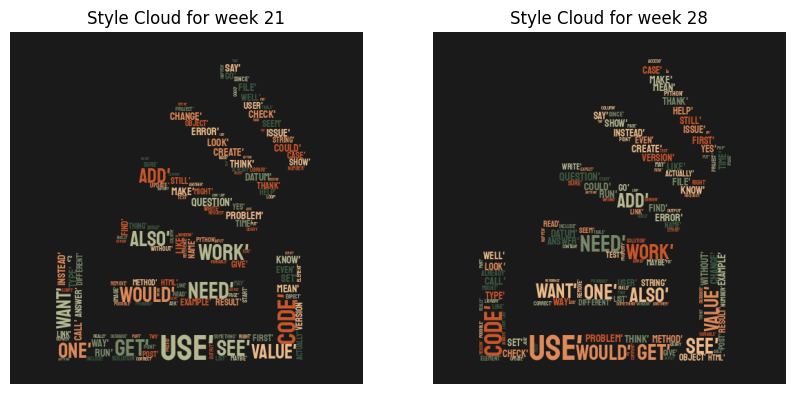

In [45]:
df_21['filtered_tokens'].to_csv("tokens_df_21.csv",index= False)
df_28['filtered_tokens'].to_csv("tokens_df_28.csv",index= False)
stylecloud.gen_stylecloud(
    file_path="tokens_df_21.csv",  # CSV with tokens for the first style cloud
    background_color="#1A1A1A",
    icon_name="fab fa-stack-overflow",
    palette="cartocolors.diverging.Fall_6",
    output_name="stylecloud_21.png",  # Save to this file
)

# Generate style cloud for df_28
stylecloud.gen_stylecloud(
    file_path="tokens_df_28.csv",  # CSV with tokens for the second style cloud
    background_color="#1A1A1A",
    icon_name="fab fa-stack-overflow",
    palette="cartocolors.diverging.Fall_6",
    output_name="stylecloud_28.png",  # Save to this file
)

# Load the generated style clouds
img1 = mpimg.imread("stylecloud_21.png")  # The first style cloud
img2 = mpimg.imread("stylecloud_28.png")  # The second style cloud

# Create a subplot with 1 row and 2 columns to display the clouds side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the style clouds
ax[0].imshow(img1)
ax[0].axis("off")  # Hide axes
ax[0].set_title("Style Cloud for week 21")

ax[1].imshow(img2)
ax[1].axis("off")  # Hide axes
ax[1].set_title("Style Cloud for week 28")

# Show the plot with both style clouds
plt.show()

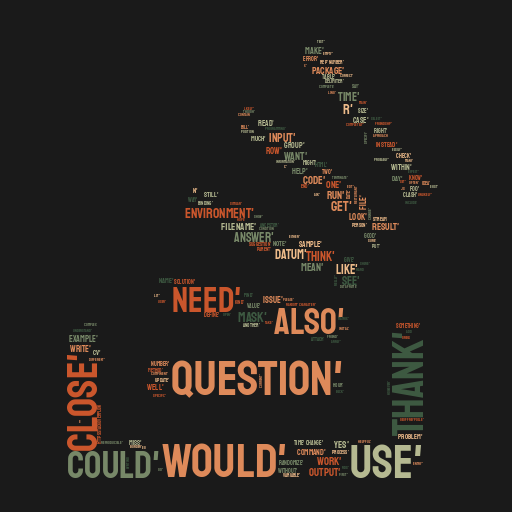

In [47]:
# Generate a word cloud for "css"
generate_wordcloud(df_exploded_7, "r", output_file="stylecloud_css.png")

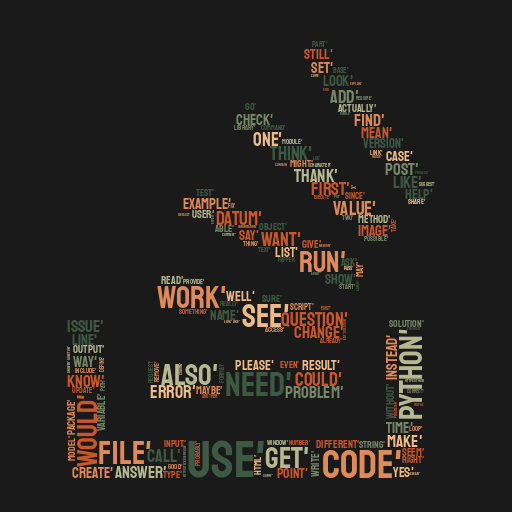

In [ ]:
# Generate a word cloud for "python"
generate_wordcloud(df_exploded_7, "python", output_file="stylecloud_python.png")

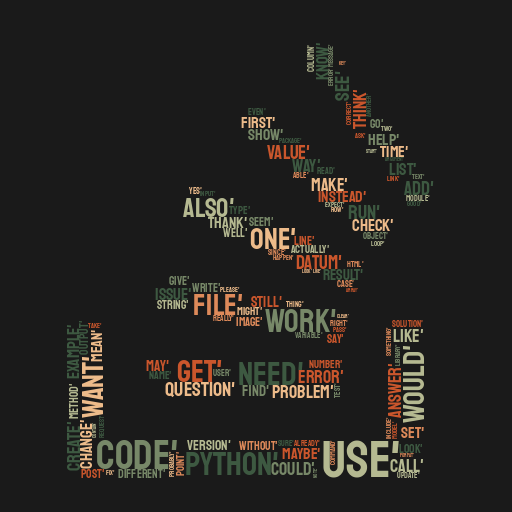

In [46]:
generate_wordcloud(df_exploded_28, "python", output_file="stylecloud_python.png")

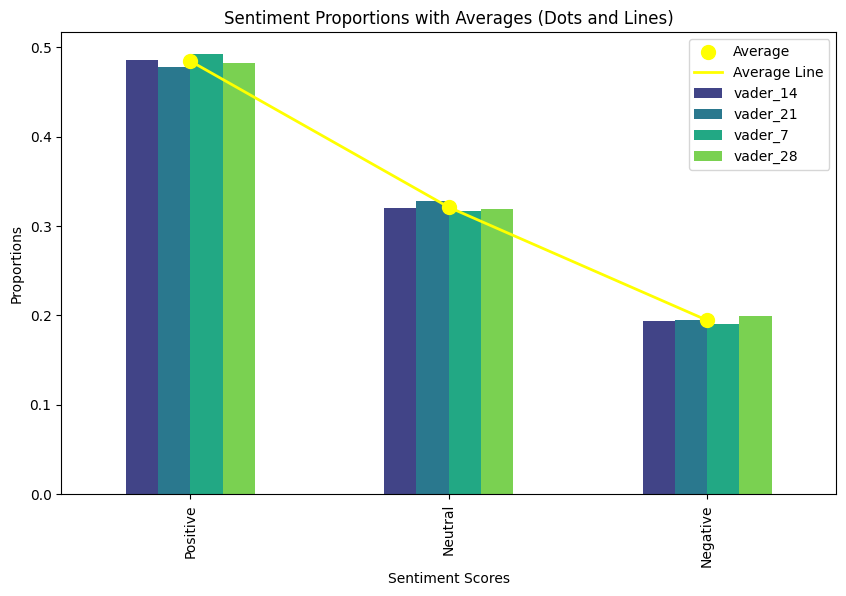

In [50]:
viridis_palette = sns.color_palette("viridis", n_colors=merged_proportions.shape[1] - 1)

ax = merged_proportions.iloc[:, :-1].plot(
    kind='bar',
    figsize=(10, 6),
    title='Sentiment Proportions with Averages (Dots and Lines)',
    xlabel='Sentiment Scores',
    ylabel='Proportions',
    color=viridis_palette,  # Using the viridis palette for the bars
)

# Step 2: Add the dots for the average
x_coords = list(range(len(merged_proportions.index)))

# Define the color for the average dots and line
avg_color = 'yellow'  # Consistent color for average

# Add the dots for the average
ax.scatter(
    x_coords,
    merged_proportions['average'],
    color=avg_color,
    s=100,  # size of the dots
    label='Average'
)

# Step 3: Connect the dots with lines
ax.plot(
    x_coords,
    merged_proportions['average'],
    color=avg_color,
    linewidth=2,
    linestyle='-',  # solid line to connect dots
    label='Average Line'
)

# Show the legend
ax.legend()

# Display the plot
plt.show()

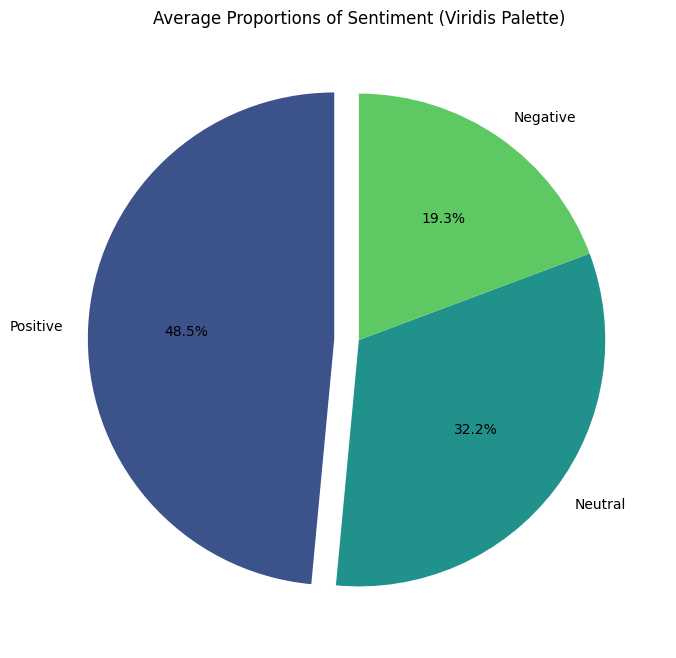

In [ ]:
# plot showing the VADER sentiment resulst distribution
average_proportions = merged_proportions['average']
num_colors = len(average_proportions.index)

# Generate a list of colors from the viridis palette
viridis_colors = sns.color_palette("viridis", n_colors=num_colors)

# Step 2: Create the pie chart with viridis colors
plt.figure(figsize=(8, 8))
plt.pie(
    average_proportions,
    labels=average_proportions.index,  # Labels for the pie slices
    autopct='%1.1f%%',  # Display the proportion as a percentage
    startangle=90,  # Start angle for the pie chart
    colors=viridis_colors,  # Use the viridis palette
    explode=[0.1] + [0] * (num_colors - 1),  # Optionally explode the first slice
)
plt.title('Average Proportions of Sentiment (Viridis Palette)')
plt.show()

<ipython-input-67-271123e652a7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['colors'] = df['sentence_sentiments'].map(color_dict)


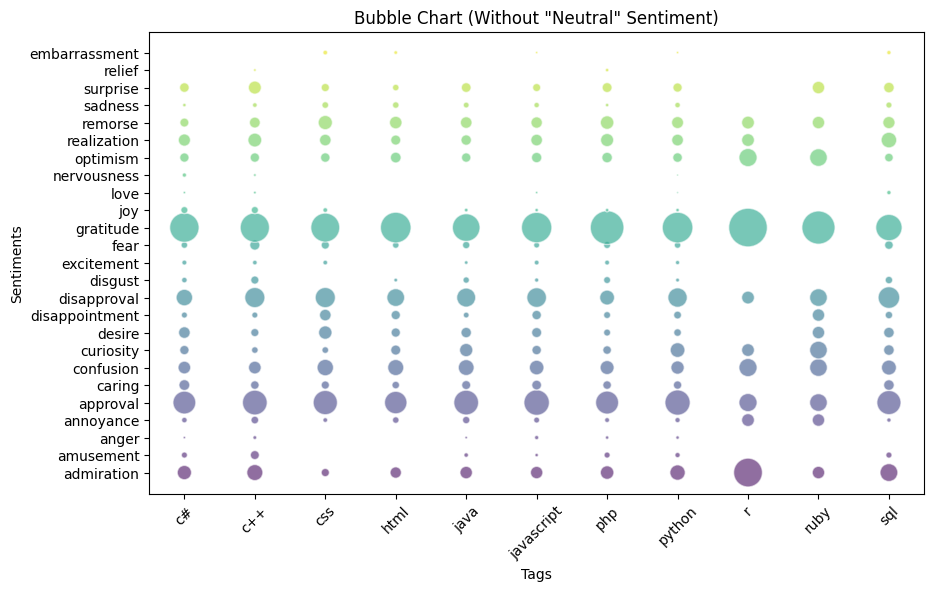

In [ ]:
plot_bubble_chart(grouped_with_totals_21)

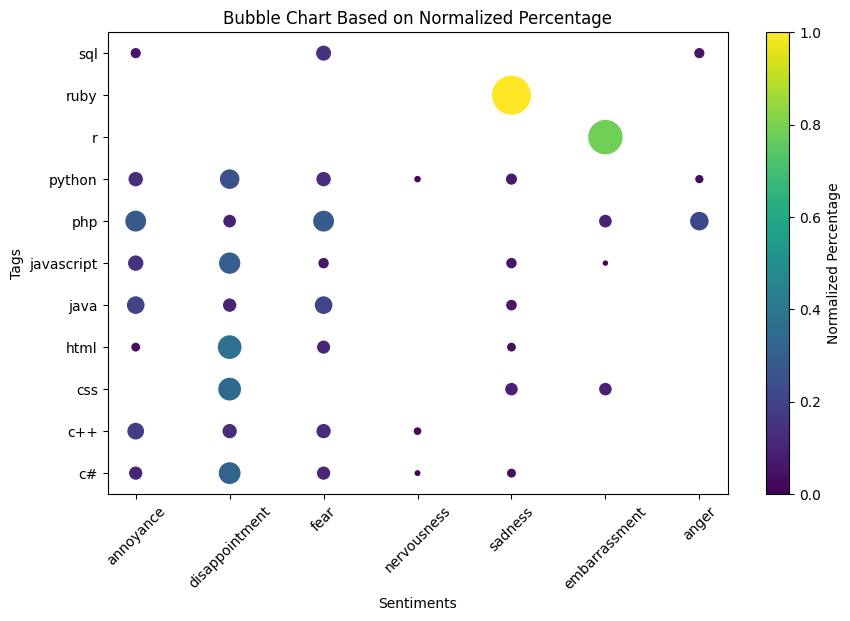

In [ ]:
negative_df_7 = grouped_with_totals_7[grouped_with_totals_7['sentence_sentiments'].isin(negative_sentiments_list)]
normalized_negative_df_7 = normalize_percentage(negative_df_7)
plot_bubble_chart_with_gradient(normalized_negative_df_7)

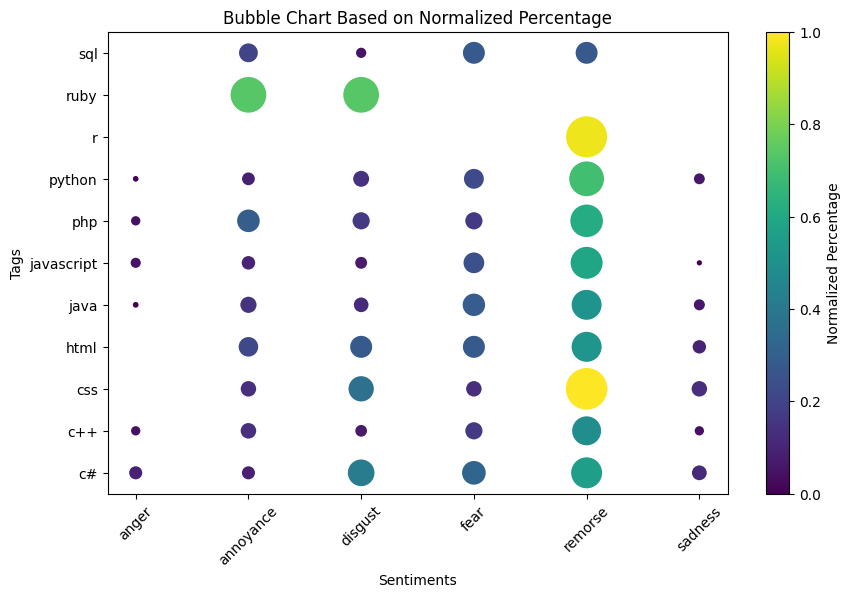

In [ ]:
negative_df_14 = grouped_with_totals_14[grouped_with_totals_14['sentence_sentiments'].isin(negative_sentiments)]
normalized_negative_df_14 = normalize_percentage(negative_df_14)
plot_bubble_chart_with_gradient(normalized_negative_df_14)

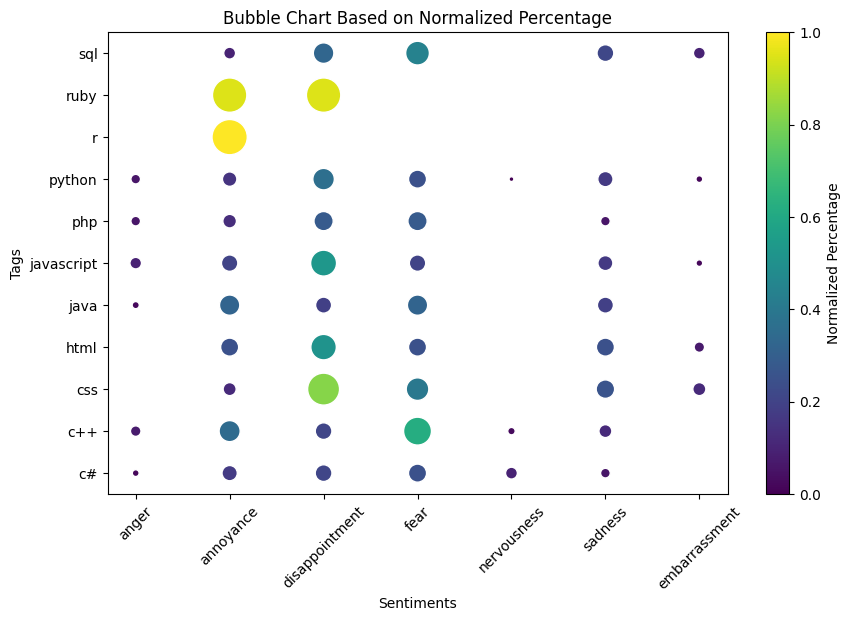

In [ ]:
negative_df_21 = grouped_with_totals_21[grouped_with_totals_21['sentence_sentiments'].isin(negative_sentiments_list)]
normalized_negative_df_21 = normalize_percentage(negative_df_21)
plot_bubble_chart_with_gradient(normalized_negative_df_21)

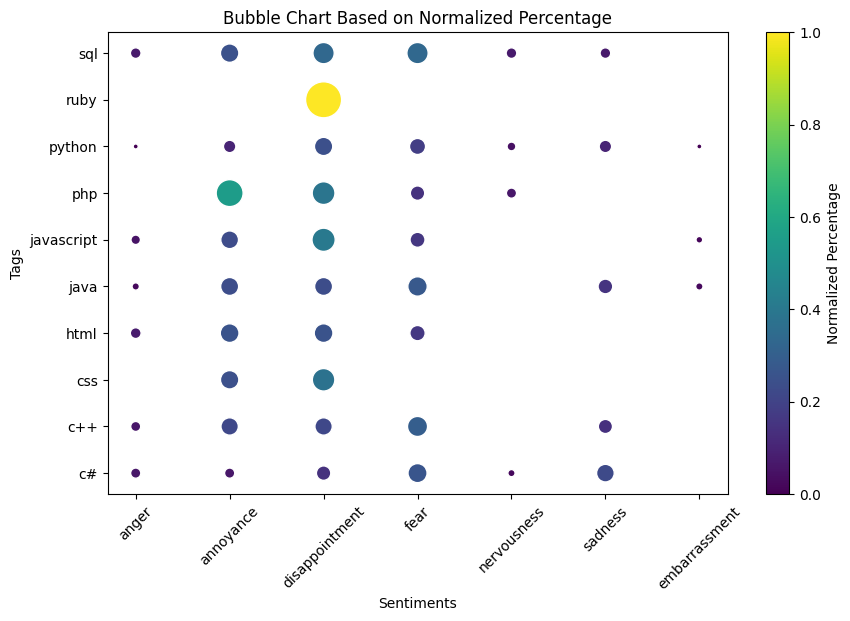

In [61]:
negative_df_28 = grouped_with_totals_28[grouped_with_totals_28['sentence_sentiments'].isin(negative_sentiments_list)]
normalized_negative_df_28 = normalize_percentage(negative_df_28)
plot_bubble_chart_with_gradient(normalized_negative_df_28)

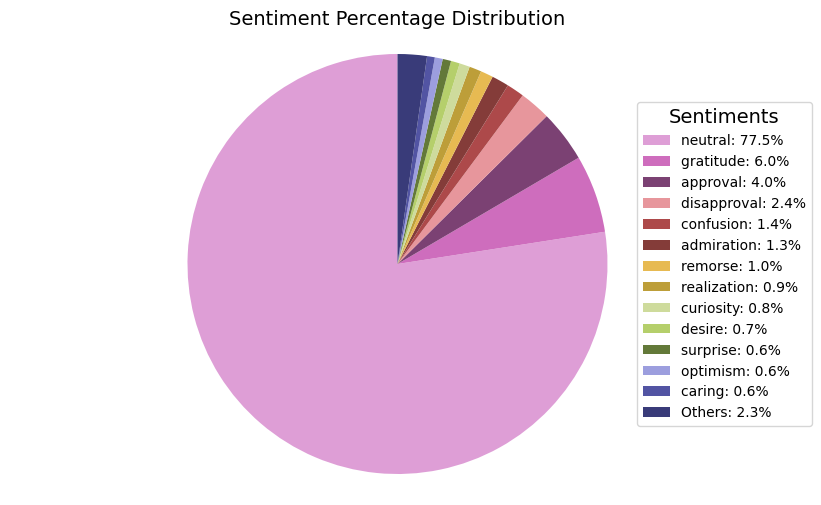

In [60]:
plot_pie_chart(sentiment_percentages_14)

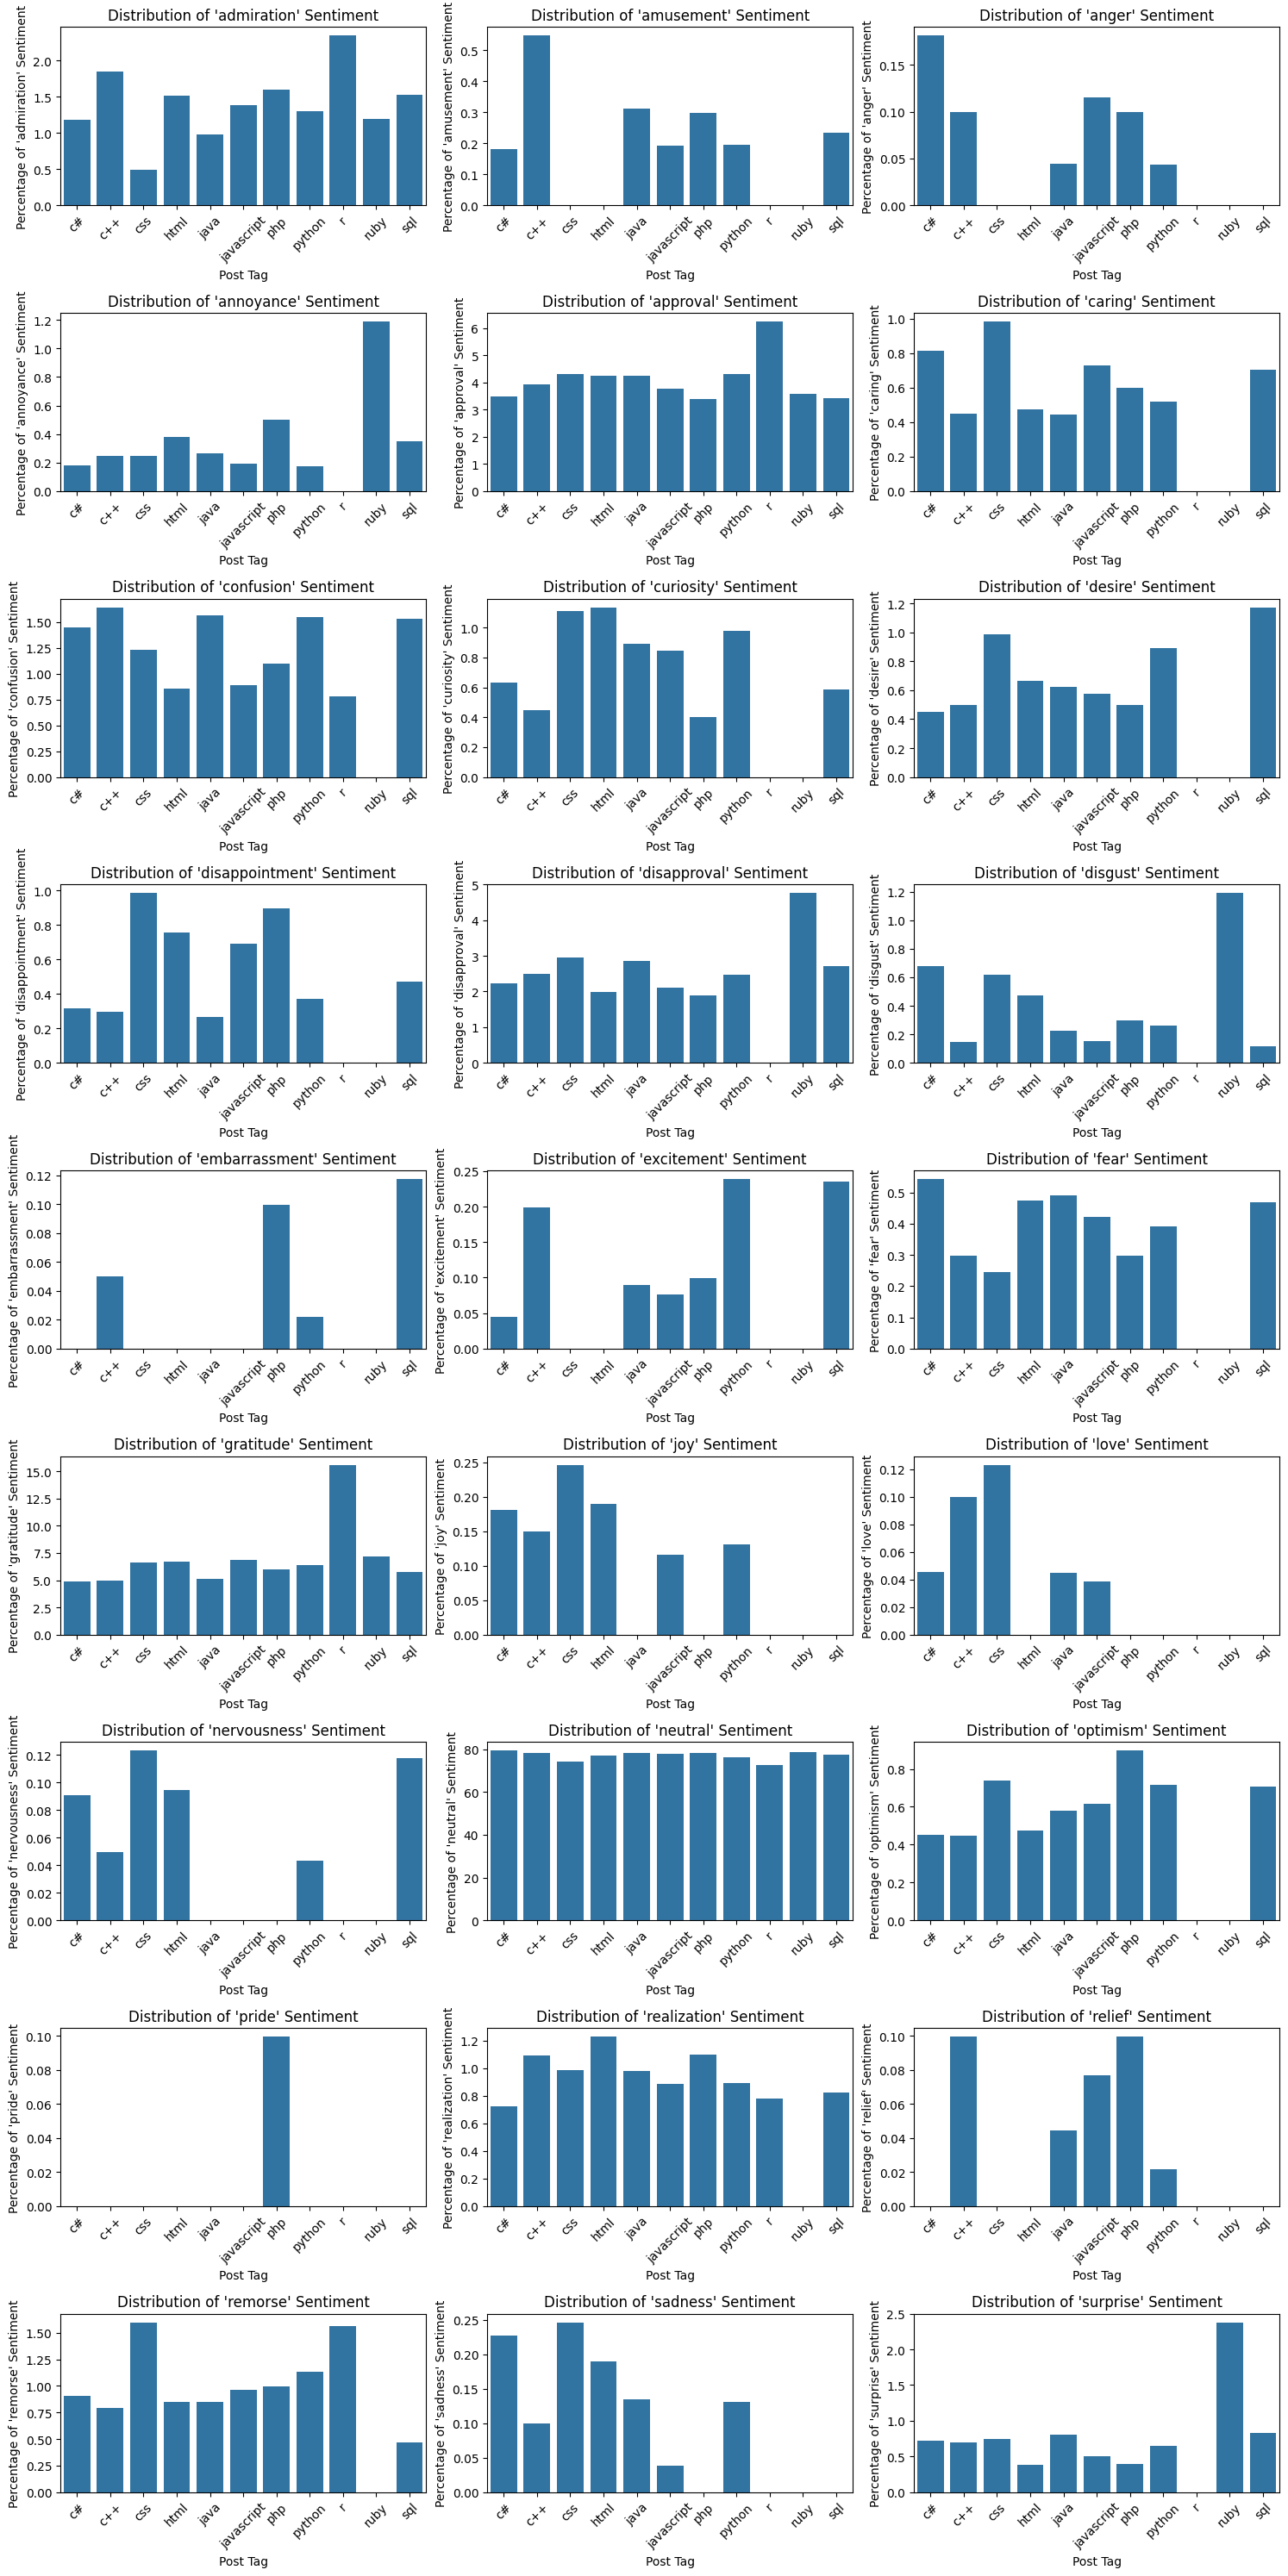

In [ ]:
plot_sentiment_distribution(df_exploded_14)

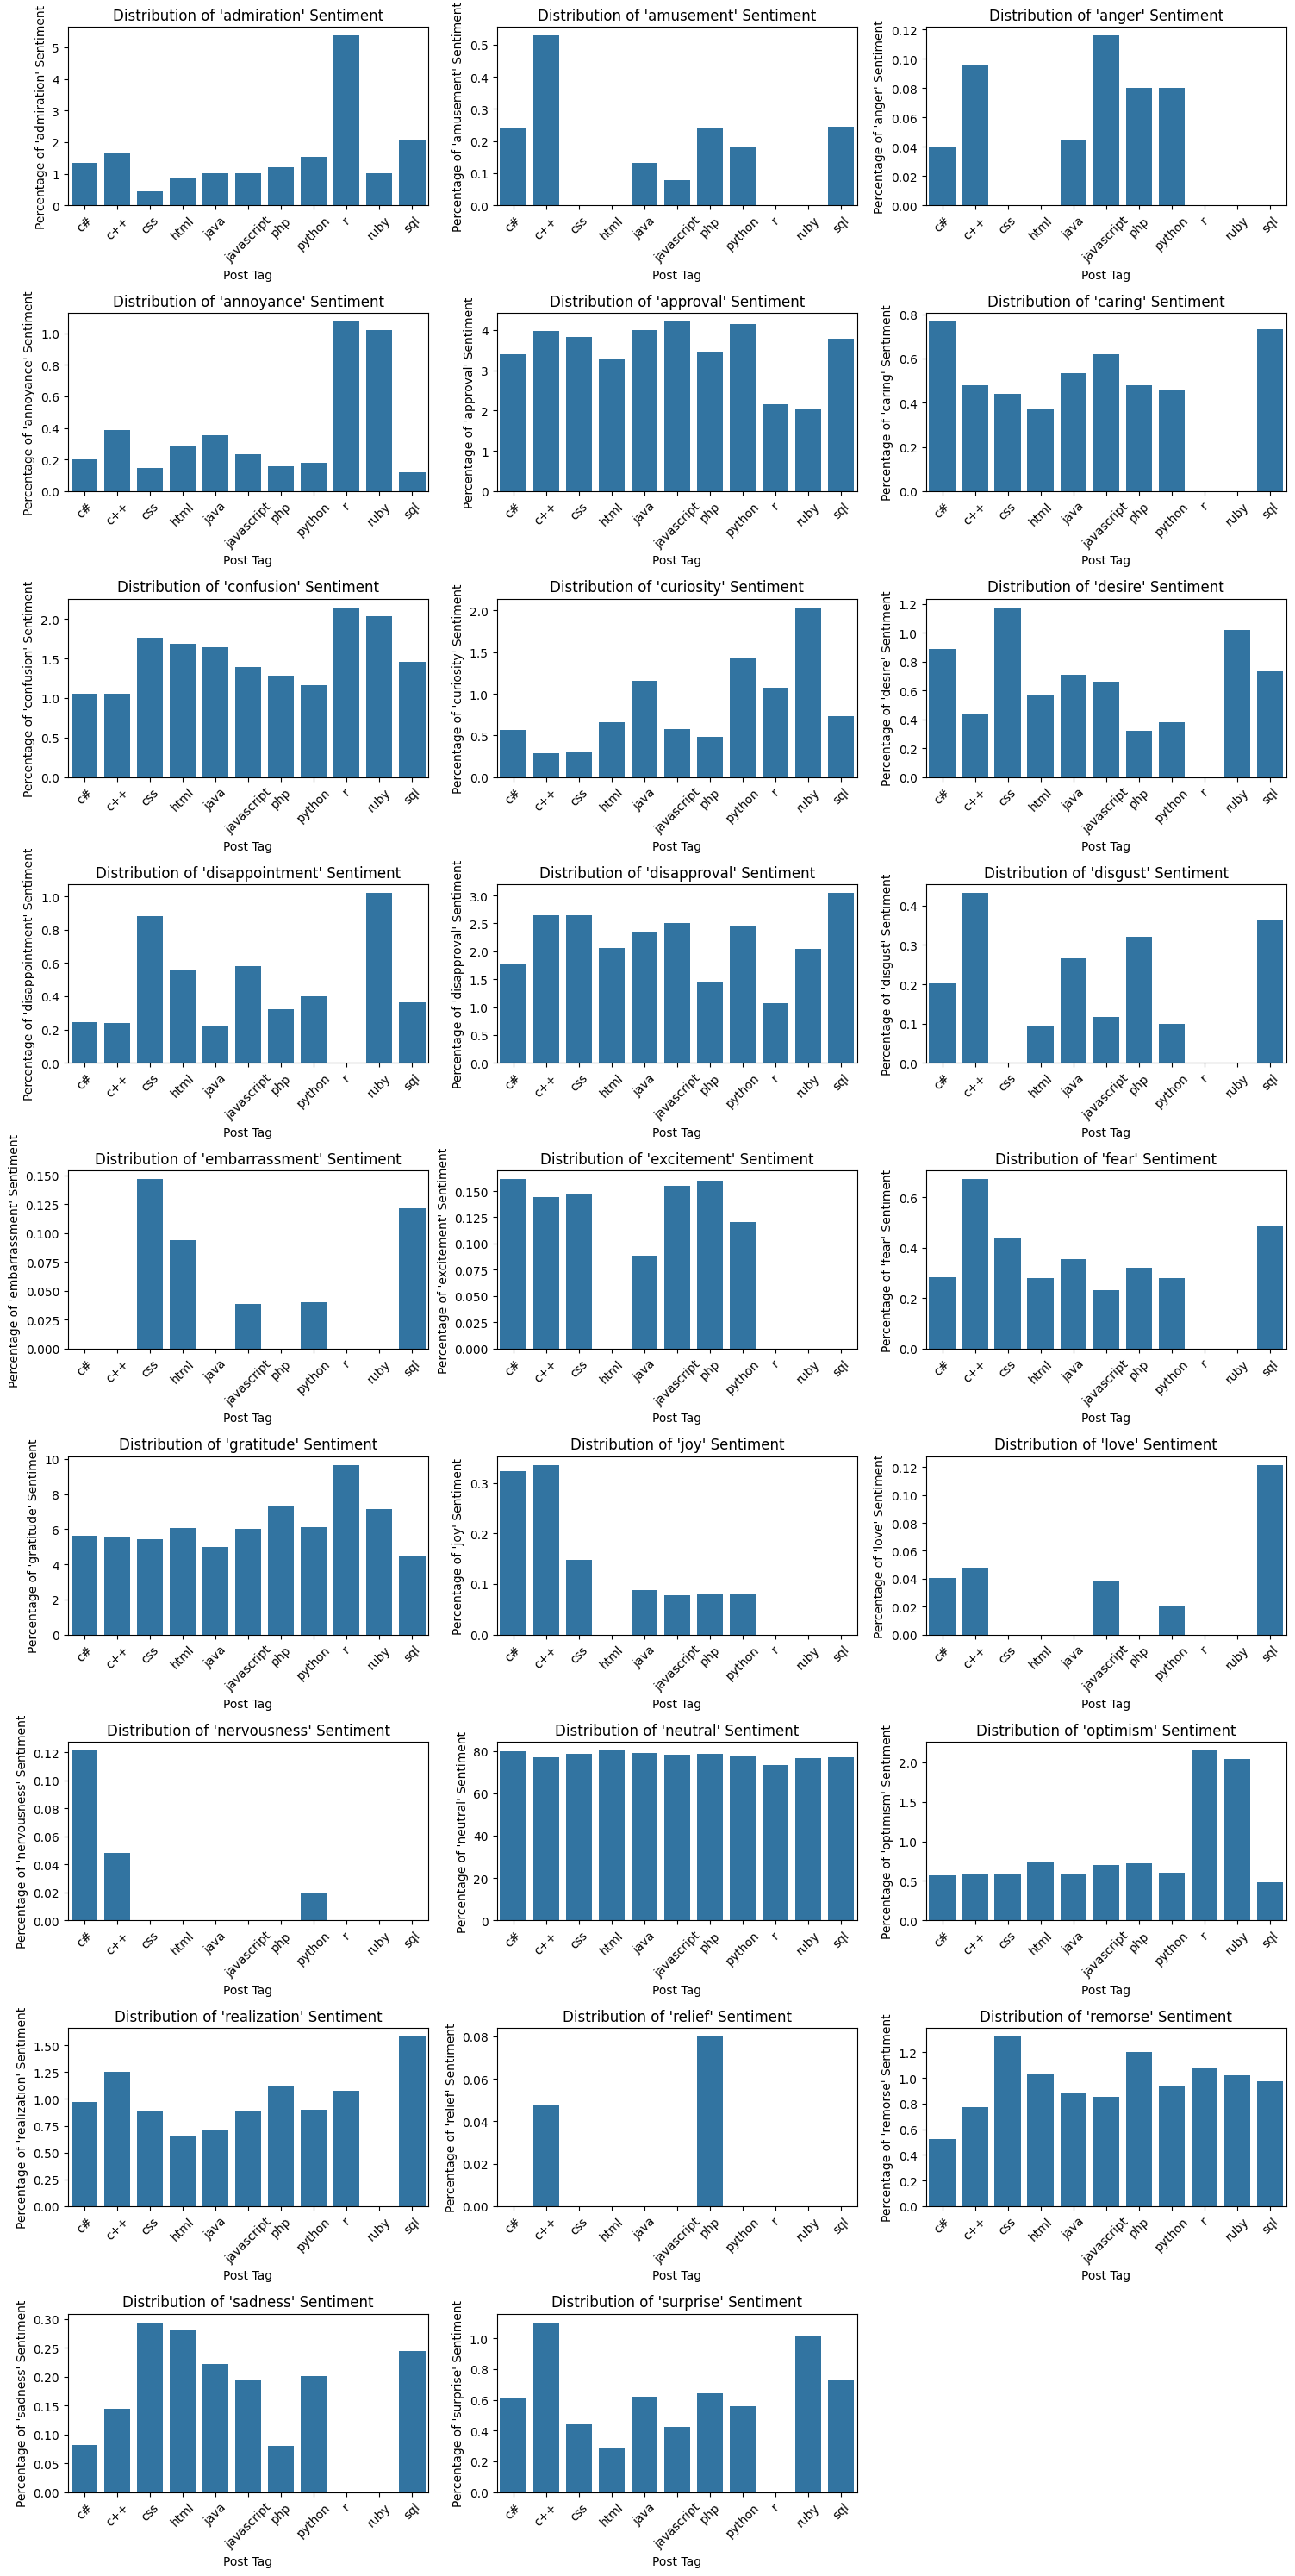

In [ ]:
plot_sentiment_distribution(df_exploded_21)

<ipython-input-87-0a41e5699a3a>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(data=df_combined, x='post_tag', y='percentage', hue='sentence_sentiments', ci=None)


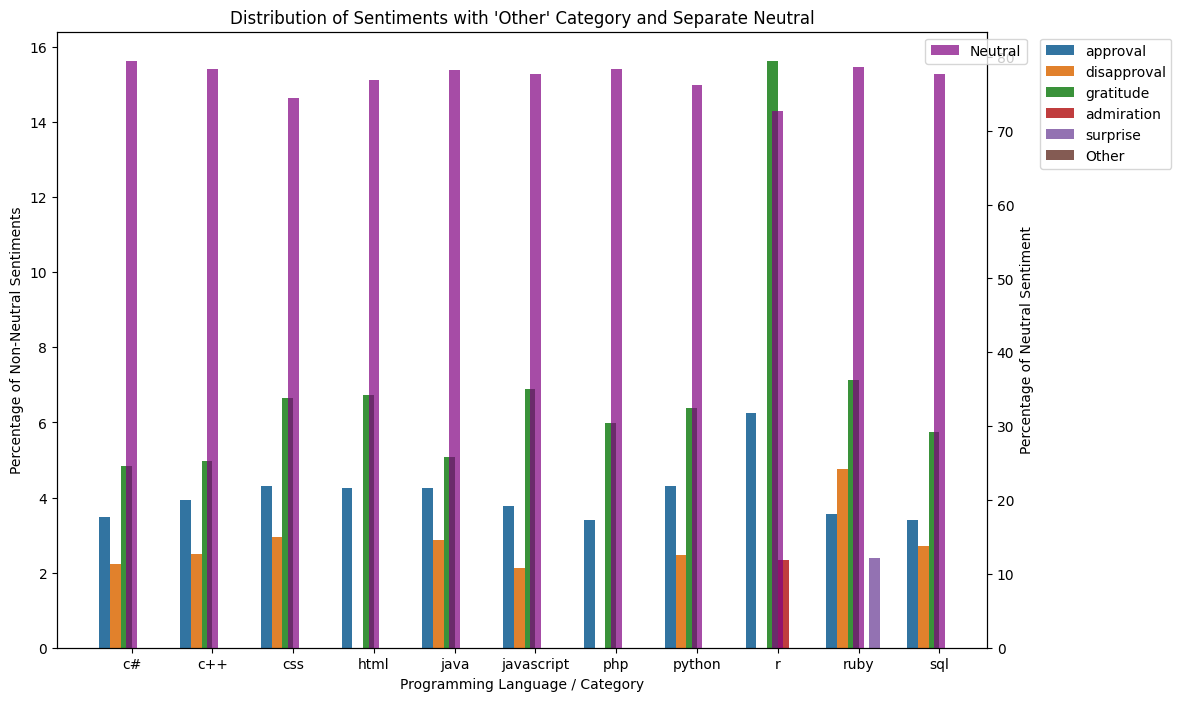

In [ ]:
# plot for week 14 (df in this case is grouped_with_totals)
threshold = 2

# Prepare the data
df_combined, df_neutral = prepare_highest_and_other_with_neutral(grouped_with_totals_14, threshold)

# Plotting
plt.figure(figsize=(12, 8))

# Primary y-axis with non-neutral sentiments
ax1 = sns.barplot(data=df_combined, x='post_tag', y='percentage', hue='sentence_sentiments', ci=None)

# Set labels for the primary y-axis
ax1.set_xlabel("Programming Language / Category")
ax1.set_ylabel("Percentage of Non-Neutral Sentiments")
ax1.set_title("Distribution of Sentiments with 'Other' Category and Separate Neutral")

# Create a secondary y-axis for neutral sentiment
ax2 = ax1.twinx()  # Create a twin Axes sharing the x-axis
bar_width = ax1.patches[0].get_width()
# Plot the neutral sentiment with slightly different settings
ax2.bar(df_neutral['post_tag'], df_neutral['percentage'], color='purple', alpha=0.7, label='Neutral', width=bar_width)

# Set labels for the secondary y-axis
ax2.set_ylabel("Percentage of Neutral Sentiment")

# Separate legends for both axes
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()

In [ ]:
# pivot_table = create_pivot_table(grouped_with_totals_14)
# plot_sentiments_from_pivot(pivot_table)